# 1. Introduction

Climate change is one of the most critical challenges of our time, with far-reaching effects on human health, particularly among vulnerable populations such as young children. High temperatures, a prominent consequence of climate change, are increasingly linked to negative health outcomes, including poor child nutrition. This study investigates the relationship between rising temperatures and anthropometric measures (such as weight-for-age and height-for-age) in children aged 1 to 5, across regions as defined by the World Bank.

Our objective is to analyze how temperature fluctuations influence child nutrition by combining historical climate and anthropometric data. Key questions include understanding how temperature changes affect child health, identifying which regions are most impacted, and examining how socio-economic factors moderate these effects.


# 2. Data Overview

For this study, we leveraged three key data sources: the Demographic and Health Surveys (DHS), which provided pre-processed anthropometric measurements for children in the form of Z-scores; climate data from the University of Delaware’s gridded station-based dataset, which offered detailed temperature records; and the World Bank Official Boundaries file, which contains official boundary information, including revisions by region, subregion, and economic status (state of development).

**1.Demographic and Health Surveys (DHS):**

   **•	Timeframe:** We selected surveys conducted between 1986 and 2018.
    
   **•	Geographic Scope:** The DHS dataset covers 54 countries, predominantly in developing regions, allowing for a diverse and comprehensive analysis of child health and nutrition across different climatic and socio-economic environments.

   **•	Data Collected:**
    
   **•	  Child Anthropometric Data:** Weight-for-age (WAZ) and weight-for-height (WHZ) scores, which are critical indicators of child malnutrition.
   
   **•	  Household Socioeconomic Information:** Includes household wealth, income, parental education, and access to sanitation, which are crucial in determining a household’s vulnerability to climatic conditions.
   
   **•	  Type of Residence:** Rural or urban classification, which allows for comparative analysis of the impacts of temperature between these areas.
    
   **•	  Geo-location (GPS):** The DHS includes GPS data, which enables the spatial analysis of temperature effects on child health outcomes.
    
**2.Climate Data (University of Delaware Gridded Dataset):**

   **•	Timeframe:** Monthly temperature data spanning from 1900 to 2008, covering the period relevant for our analysis of DHS data.
   
   **•	Mapping to DHS Data:** We linked the DHS GPS coordinates to the corresponding climate grid cell, allowing us to map the historical climate data (specifically, monthly temperature) to individual children’s location in the survey.
   
**3.World Bank Official Boundaries:**

 **•	Data Provided:** Contains official boundaries with detailed regional and subregional revisions, along with economic classifications (state of development), enriching the socio-economic and geographic context for our analysis.

# 3. Cleaning and Transforming data

## Load Libraries

In [1]:
# Load necessary libraries
library(dplyr)
library(sandwich)
library(lmtest)
library(fixest)
library(tidyverse)
library(haven)
library(ggplot2) 
library(sf)        
library(modelsummary)
library(dotwhisker)
library(gapminder)
library(broom)



Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ ggplot2   3.5.1     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE



`modelsummary` 2.0.0 now uses `tinytable` as its default table-drawing
  backend. Learn more at: https://vincentarelbundock.github.io/tinytable/

Revert to `kableExtra` for one session:

  options(modelsummary_factory_default = 'kableExtra')
  options(modelsummary_factory_latex = 'kableExtra')
  options(modelsummary_factory_html = 'kableExtra')

Silence this message forever:

  config_modelsummary(startup_message = FALSE)



## Load Data Sets

In [2]:
# list. files in path 
list.files(path = "/kaggle/input/")
# Load DHS Dataset
dhs_anthro <- read_dta("/kaggle/input/children-anthropometics-dhs-cleaned/child_anthro_gps_t2m.dta")
# Load shapefile from World Bank Countries Boundaries 
shapefile_data <- st_read("/kaggle/input/shape-file-wb-country-boundaries")

[1] "children-anthropometics-dhs-cleaned"        
[2] "csv-file-from-world-bank-country-boundaries"
[3] "shape-file-wb-country-boundaries"

Reading layer `WB_countries_Admin0_10m' from data source 
  `/kaggle/input/shape-file-wb-country-boundaries' using driver `ESRI Shapefile'
Simple feature collection with 251 features and 52 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -180 ymin: -59.47275 xmax: 180 ymax: 83.6341
Geodetic CRS:  WGS 84


## Inspect data 

In [3]:
# Display first 5 rows from DHS data
head(dhs_anthro, 5)
# Display columns names
colnames(dhs_anthro)

child_who_wght4age_z child_who_hght4age_z child_who_bmi4age_z
1 -1.47                -1.55                -0.78              
2  0.09                -1.06                 1.08              
3 -1.62                -2.83                 0.35              
4 -0.79                -1.99                 0.57              
5 -1.49                -1.97                -0.41              
  child_who_wght4hght_z child_who_wght4hght_fl child_who_hght4age_fl
1 -0.64                 0                      0                    
2  0.94                 0                      0                    
3  0.16                 0                      0                    
4  0.17                 0                      0                    
5 -0.77                 0                      0                    
  child_who_wght4age_fl child_who_bmi4age_fl caseid          country ⋯ t2m tmax
1 0                     0                          292  4  3 lesotho ⋯ NA  NA  
2 0                     0                          292196  2 lesotho ⋯ NA  NA  
3 0                     0                           47311  3 lesotho ⋯ NA  NA  
4 0                     0                          292 79  2 lesotho ⋯ NA  NA  
5 0                     0                          292 79  8 lesotho ⋯ NA  NA  
  tmin d2m tp si10 tcc elevation t2y _merge_clim_matrix
1 NA   NA  NA NA   NA  NA        NA  1                 
2 NA   NA  NA NA   NA  NA        NA  1                 
3 NA   NA  NA NA   NA  NA        NA  1                 
4 NA   NA  NA NA   NA  NA        NA  1                 
5 NA   NA  NA NA   NA  NA        NA  1

[1] "child_who_wght4age_z"        "child_who_hght4age_z"       
 [3] "child_who_bmi4age_z"         "child_who_wght4hght_z"      
 [5] "child_who_wght4hght_fl"      "child_who_hght4age_fl"      
 [7] "child_who_wght4age_fl"       "child_who_bmi4age_fl"       
 [9] "caseid"                      "country"                    
[11] "adm_region"                  "cluster_id"                 
[13] "dhscc"                       "dhsphase"                   
[15] "dhs_smpl_wgt_raw"            "dhs_smpl_wgt_adj"           
[17] "interview_month"             "interview_year"             
[19] "interview_day"               "survey_year"                
[21] "w_birth_month"               "w_birth_year"               
[23] "age"                         "rural"                      
[25] "urban"                       "edu_none"                   
[27] "edu_primary"                 "edu_secondary"              
[29] "edu_higher"                  "edu_singleyrs"              
[31] "illiterate"                  "semiliterate"               
[33] "literate"                    "unmarried"                  
[35] "married"                     "widowed"                    
[37] "divorced"                    "marriage_year"              
[39] "sterilized"                  "hh_water_piped"             
[41] "hh_water_well"               "hh_water_surface"           
[43] "hh_water_transport"          "water_source_string"        
[45] "water_source_v113"           "hh_wealth_ind"              
[47] "total_children"              "total_sons"                 
[49] "total_daughters"             "birth_year"                 
[51] "birth_month"                 "birth_order"                
[53] "male"                        "female"                     
[55] "child_low_birth_weight"      "child_birth_subj_size"      
[57] "child_age_mnths"             "dhsid"                      
[59] "std_adm_region"              "adm_code_error"             
[61] "onesurvey"                   "totalsurveys"               
[63] "surveysize"                  "wght_avgcountry"            
[65] "LATNUM"                      "LONGNUM"                    
[67] "ALT_GPS"                     "ALT_DEM"                    
[69] "dup_id"                      "water_source_who_unimproved"
[71] "water_source_surface_who"    "year"                       
[73] "month"                       "latitude"                   
[75] "longitude"                   "v1"                         
[77] "t2m"                         "tmax"                       
[79] "tmin"                        "d2m"                        
[81] "tp"                          "si10"                       
[83] "tcc"                         "elevation"                  
[85] "t2y"                         "_merge_clim_matrix"

In [4]:
# Display the first 2 rows of the data
head(shapefile_data, 2)

# Display the column names of the data
colnames(shapefile_data)

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



OBJECTID featurecla      LEVEL TYPE              FORMAL_EN            
1 1        Admin-0 country 2     Sovereign country Republic of Indonesia
2 2        Admin-0 country 2     Sovereign country Malaysia             
  FORMAL_FR POP_EST   POP_RANK GDP_MD_EST POP_YEAR
1 NA        260580739 17       3028000    2017    
2 NA         31381992 15        863000    2017    
  geometry                       ⋯ NAME_SV    NAME_TR   NAME_VI   NAME_ZH   
1 MULTIPOLYGON (((117.7036 4.... ⋯ Indonesien Endonezya Indonesia 印度尼西亚
2 MULTIPOLYGON (((117.7036 4.... ⋯ Malaysia   Malezya   Malaysia  马来西亚  
  WB_NAME   WB_RULES WB_REGION Shape_Leng Shape_Area
1 Indonesia None     EAP       495.02992  153.07861 
2 Malaysia  None     EAP        68.45691   26.70317 
  geometry                      
1 MULTIPOLYGON (((117.7036 4....
2 MULTIPOLYGON (((117.7036 4....

[1] "OBJECTID"   "featurecla" "LEVEL"      "TYPE"       "FORMAL_EN" 
 [6] "FORMAL_FR"  "POP_EST"    "POP_RANK"   "GDP_MD_EST" "POP_YEAR"  
[11] "LASTCENSUS" "GDP_YEAR"   "ECONOMY"    "INCOME_GRP" "FIPS_10_"  
[16] "ISO_A2"     "ISO_A3"     "ISO_A3_EH"  "ISO_N3"     "UN_A3"     
[21] "WB_A2"      "WB_A3"      "CONTINENT"  "REGION_UN"  "SUBREGION" 
[26] "REGION_WB"  "NAME_AR"    "NAME_BN"    "NAME_DE"    "NAME_EN"   
[31] "NAME_ES"    "NAME_FR"    "NAME_EL"    "NAME_HI"    "NAME_HU"   
[36] "NAME_ID"    "NAME_IT"    "NAME_JA"    "NAME_KO"    "NAME_NL"   
[41] "NAME_PL"    "NAME_PT"    "NAME_RU"    "NAME_SV"    "NAME_TR"   
[46] "NAME_VI"    "NAME_ZH"    "WB_NAME"    "WB_RULES"   "WB_REGION" 
[51] "Shape_Leng" "Shape_Area" "geometry"

## Renaming column from the data set from DHS

In [5]:
# Rename Specific Columns:
dhs_anthro_2 <- dhs_anthro %>%
  rename(WAZ = child_who_wght4age_z,
         WAZF = child_who_wght4age_fl,
         HAZ = child_who_hght4age_z,
         HAZF = child_who_hght4age_fl,
         WHZ = child_who_wght4hght_z,
         WHZF = child_who_wght4hght_fl,
         Monthly_Temperature = t2m,
         Age_in_months = child_age_mnths,
         Female = female,
         Rural = rural,
         Birth_order = birth_order,
         Mothers_age = age,
         Married = married,
         Literate = literate,
         Total_children = total_children,
         Water_source_unimproved = water_source_who_unimproved,
         Country = country,
         Adm_Region = adm_region,
         Year = year,
         Month = month)

## Create Region_id 

Given that some std_adm_region values in the dataset are shared by different countries, creating ambiguity, it’s important to distinguish these regions for more accurate analysis. To resolve this, we generate a new variable, Region_id, by combining both the std_adm_region and Country fields. This ensures each region is uniquely identified within its specific country context.

This method enhances the precision of our geographical categorization, preventing overlap between similarly named regions across different countries and providing more reliable insights during analysis

In [6]:
# Create variable Region_id
dhs_anthro_2 <- dhs_anthro_2 %>% mutate(Region_id = interaction(std_adm_region, Country))

## Select useful columns for each dataset

From the datasets, we carefully selected the most relevant columns to ensure a focused and efficient analysis. These columns were chosen based on their significance in addressing the research objectives and include key indicators of child health, climate data, and geographic identifiers.

In [7]:
# Save specific columns from DHS dataset
dhs_anthro_selected <- dhs_anthro_2 %>%  
select(Country,Adm_Region,Region_id,Year,Month, 
       WAZ, WAZF, HAZ, HAZF, WHZ, WHZF, Age_in_months, 
       Female, Rural, Birth_order, Mothers_age , Married , 
       Literate , Total_children , Water_source_unimproved, Monthly_Temperature)
colnames(dhs_anthro_selected)  

[1] "Country"                 "Adm_Region"             
 [3] "Region_id"               "Year"                   
 [5] "Month"                   "WAZ"                    
 [7] "WAZF"                    "HAZ"                    
 [9] "HAZF"                    "WHZ"                    
[11] "WHZF"                    "Age_in_months"          
[13] "Female"                  "Rural"                  
[15] "Birth_order"             "Mothers_age"            
[17] "Married"                 "Literate"               
[19] "Total_children"          "Water_source_unimproved"
[21] "Monthly_Temperature"

In [8]:
# Save specific columns from World Bank Boundaries
wb_selected <- shapefile_data %>% 
select(WB_NAME,ISO_A3,CONTINENT,REGION_WB,SUBREGION,REGION_UN,ECONOMY)
head(wb_selected,2)

WB_NAME   ISO_A3 CONTINENT REGION_WB           SUBREGION          REGION_UN
1 Indonesia IDN    Asia      East Asia & Pacific South-Eastern Asia Asia     
2 Malaysia  MYS    Asia      East Asia & Pacific South-Eastern Asia Asia     
  ECONOMY                  geometry                      
1 4. Emerging region: MIKT MULTIPOLYGON (((117.7036 4....
2 6. Developing region     MULTIPOLYGON (((117.7036 4....

In [9]:
wb_selected$Country_name <- wb_selected$WB_NAME

## Remove NULL Values and Negative Month Temperature

In [10]:
# Display number of rows of dhs_anthro
cat("Number of rows in dhs_anthro:",nrow(dhs_anthro),"\n")

# Remove null values of Monthly_Temperature 
dhs_anthro_filtered <- dhs_anthro_selected %>%
  filter((!is.na(Monthly_Temperature) ))
# Remove negative temperature
dhs_anthro_filtered <-dhs_anthro_filtered %>%
    filter(Monthly_Temperature > 0)
# Display number of rows of dhs_anthro
cat("Number of rows in dhs_anthro_filtered:",nrow(dhs_anthro_filtered))


Number of rows in dhs_anthro: 669013 


Number of rows in dhs_anthro_filtered: 574837

## Change names of countries 

Since the DHS dataframe contains country names in a different format compared to the World Bank dataframe, it was necessary to standardize the country names in the World Bank dataset. This adjustment ensures consistency across both datasets, allowing for accurate merging and analysis.

In [11]:
# Convert WB_NAME to lowercase
wb_selected <- wb_selected %>% mutate(WB_NAME = tolower(WB_NAME))

# Change name of specific countries 
wb_selected_2 <- wb_selected %>%
  mutate(WB_NAME = case_when(
    WB_NAME == "kyrgyz republic" ~ "kyrgyz_republic",
    WB_NAME == "central african republic" ~ "central_african_republic",
    WB_NAME == "côte d\'ivoire" ~ "cote_divoire",
    WB_NAME == "congo, rep. of" ~ "congo_drc",
    WB_NAME == "timor-leste" ~ "timor_leste",
    WB_NAME == "burkina faso" ~ "burkina_faso",
    WB_NAME == "dominican republic" ~ "dominican_republic",
    WB_NAME == "sierra leone" ~ "sierra_leone",
    WB_NAME == "eswatini" ~ "swaziland",
    WB_NAME == "egypt, arab republic of" ~ "egypt",  
    TRUE ~ WB_NAME  # Keep all other values unchanged
  ))

# Check for rows where SUBREGION is NA or empty
missing_subregion_rows <- wb_selected_2 %>%
    filter(WB_NAME=='swaziland')
  #filter(is.na(SUBREGION) | SUBREGION == "")

# Display the result
missing_subregion_rows


WB_NAME   ISO_A3 CONTINENT REGION_WB          SUBREGION       REGION_UN
1 swaziland SWZ    Africa    Sub-Saharan Africa Southern Africa Africa   
  ECONOMY              geometry                       Country_name
1 6. Developing region MULTIPOLYGON (((31.94924 -2... eSwatini

## Join Dataframes DHS and WorldBank Boundaries

In [12]:
# Perform the join, matching WB_NAME in wb_selected with Country in dhs_anthro_selected
joined_data <- left_join(dhs_anthro_filtered, wb_selected_2, by = c("Country" = "WB_NAME"))

# View the first few rows of the joined data
head(joined_data,3)

Country Adm_Region Region_id       Year Month WAZ   WAZF HAZ   HAZF WHZ   ⋯
1 lesotho quthing    quthing.lesotho 2014 9     -1.26 0    -0.92 0    -1.15 ⋯
2 lesotho quthing    quthing.lesotho 2014 9     -1.90 0    -3.54 0     0.03 ⋯
3 lesotho quthing    quthing.lesotho 2014 9     -0.24 0    -1.90 0     1.28 ⋯
  Water_source_unimproved Monthly_Temperature ISO_A3 CONTINENT
1 1                       14.15249            LSO    Africa   
2 0                       14.15249            LSO    Africa   
3 0                       14.15249            LSO    Africa   
  REGION_WB          SUBREGION       REGION_UN ECONOMY                  
1 Sub-Saharan Africa Southern Africa Africa    7. Least developed region
2 Sub-Saharan Africa Southern Africa Africa    7. Least developed region
3 Sub-Saharan Africa Southern Africa Africa    7. Least developed region
  geometry                       Country_name
1 MULTIPOLYGON (((28.98085 -2... Lesotho     
2 MULTIPOLYGON (((28.98085 -2... Lesotho     
3 MULTIPOLYGON (((28.98085 -2... Lesotho

## Convert Indicators and Apply Labels:

In this step, we convert key indicators in the dataset (such as Rural, Gender, and Water_source_unimproved) into categorical variables with appropriate labels. This process makes the data easier to interpret and visualize, ensuring that the categories are clearly defined and properly labeled for analysis.

In [13]:
# Convert the 'Rural' column to a factor for better labeling
joined_data$Rural <- factor(joined_data$Rural, levels = c(0, 1), labels = c("Urban", "Rural"))
# Convert the 'Female' column to a factor for better labeling
joined_data$Female <- factor(joined_data$Female, levels = c(0, 1), labels = c("Male", "Female"))
# Convert the 'Water_source_unimproved' column to a factor for better labeling
joined_data$Water_source_unimproved <- factor(joined_data$Water_source_unimproved, 
                                        levels = c(0, 1), labels = c("Improved", "Unimproved"))


## Filtering Data for Children Under 12 Months and Identifying Outlier Z-Scores:

In this step, we filter the dataset to include only children under 12 months of age, as infants are particularly vulnerable to climate-related impacts on health and nutrition. To ensure the quality of our analysis, we also identify outliers in the anthropometric indicators. Specifically, Z-scores greater than 6 are flagged as outliers for each indicator (WAZ, HAZ, and WHZ), since values beyond this threshold are considered biologically implausible.

For each of these Z-scores, a corresponding flag will be created to indicate whether an observation is classified as an outlier. This helps to ensure that the analysis focuses on valid anthropometric data while identifying and handling extreme or erroneous values.


In [14]:
# Filter children nutrition outcomes by age and Z-score outliers
WAZ_Dta <- joined_data %>% filter(WAZF == 0 & Age_in_months >12)
HAZ_Dta <- joined_data %>% filter(HAZF == 0 & Age_in_months >12)
WHZ_Dta <- joined_data %>% filter(WHZF == 0 & Age_in_months >12)


# 4. Summary Statistics:

In this section, we provide a comprehensive overview of key summary statistics derived from the dataset. This includes central tendency measures (mean,standard deviation,median), dispersion (standard deviation, range), and distribution characteristics for critical variables such as child anthropometric scores (WAZ,HAZ, WHZ), monthly temperature, and socio-economic indicators. These summary statistics help to identify trends, outliers, and patterns within the data, forming the foundation for deeper analytical insights.

## Summary Child Anthropometric Scores 

In [15]:
# Create a summary table for WAZ
summary_WAZ <- WAZ_Dta %>%
  summarise(
    WAZ_mean = mean(WAZ, na.rm = TRUE),
    WAZ_sd = sd(WAZ, na.rm = TRUE),
    WAZ_median = median(WAZ, na.rm = TRUE),)

# Display the summary table
summary_WAZ
# Create a summary table for HAZ
summary_HAZ <- HAZ_Dta %>%
  summarise(
    HAZ_mean = mean(HAZ, na.rm = TRUE),
    HAZ_sd = sd(HAZ, na.rm = TRUE),
    HAZ_median = median(HAZ, na.rm = TRUE),)

# Display the summary table
summary_HAZ

# Create a summary table for WHZ
summary_WHZ <- WHZ_Dta %>%
  summarise(
    WHZ_mean = mean(WHZ, na.rm = TRUE),
    WHZ_sd = sd(WHZ, na.rm = TRUE),
    WHZ_median = median(WHZ, na.rm = TRUE),)

# Display the summary table
summary_WHZ

# Create a summary table for Temperature
summary_Temperature <- joined_data %>%
  summarise(
    Temperature_mean = mean(Monthly_Temperature, na.rm = TRUE),
    Temperature_sd = sd(Monthly_Temperature, na.rm = TRUE),
    Temperature_median = median(Monthly_Temperature, na.rm = TRUE),)

# Display the summary table
summary_Temperature

WAZ_mean   WAZ_sd   WAZ_median
1 -0.9849076 1.357245 -0.95

HAZ_mean  HAZ_sd   HAZ_median
1 -1.546629 1.665769 -1.57

WHZ_mean   WHZ_sd   WHZ_median
1 -0.1284804 1.412512 -0.1

Temperature_mean Temperature_sd Temperature_median
1 23.93778         4.904069       24.95031

## Distribution of Weight-for-Age Z-Scores (WAZ)

WAZ_category           count  percentage
1 Healthy Weight-for-Age  92910 21        
2 Risk of Underweight    250272 58        
3 Underweight             89449 21

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


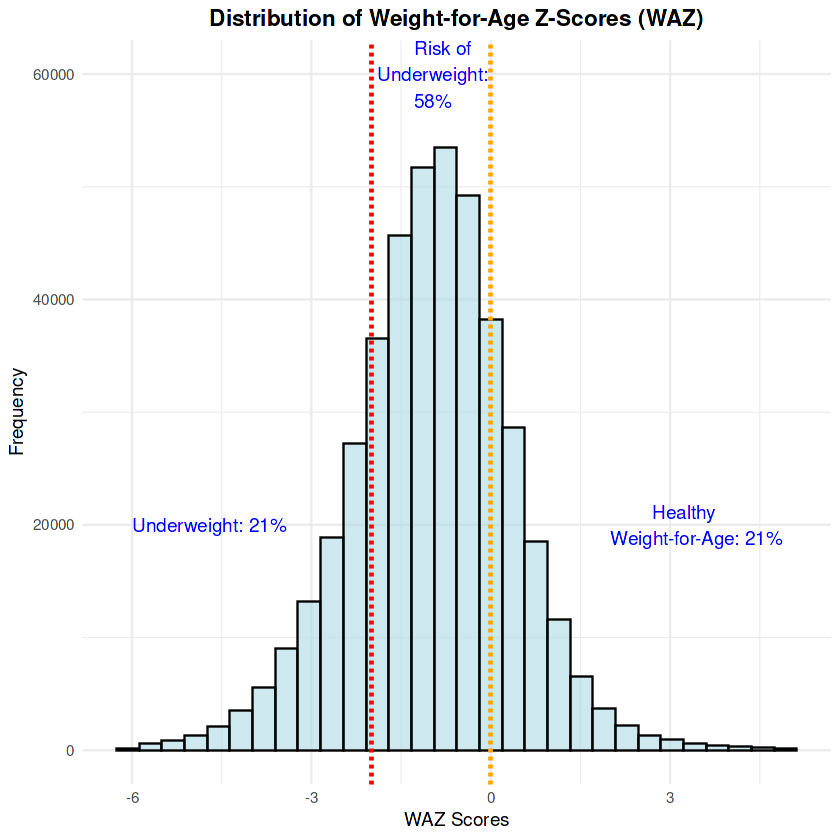

In [16]:
# First, categorize HAZ scores into nourishment categories
WAZ_Dta <- WAZ_Dta %>%
  mutate(WAZ_category = case_when(
    WAZ < -2 ~ "Underweight",
    WAZ >= -2 & WAZ <= 0 ~ "Risk of Underweight",
    WAZ > 0 ~ "Healthy Weight-for-Age"
  ))

# Calculate percentages for each WAZ category
category_percentage_WAZ <- WAZ_Dta %>%
  group_by(WAZ_category) %>%
  summarise(count = n()) %>%
  mutate(percentage = round(count / sum(count) * 100))

# View Category results
category_percentage_WAZ

# Plot histogram with percentage labels for each category
WAZ_plot <- ggplot(WAZ_Dta, aes(x = WAZ)) +
  geom_histogram(aes(y = after_stat(count)), bins = 30, fill = "lightblue", color = "black", alpha = 0.6) +
  geom_vline(xintercept = -2, linetype = "dashed", color = "red", size = 1) +  
  geom_vline(xintercept = 0, linetype = "dashed", color = "orange", size = 1) +
  # Annotate 
  annotate("text", x = -6, y = 20000, label = "Underweight: 21%", color = "blue", hjust = 0) + 
  annotate("text", x = -1.9, y = 60000, label = "       Risk of\nUnderweight:\n       58%", color = "blue", hjust = 0) + 
  annotate("text", x = 2, y = 20000, label = "        Healthy\nWeight-for-Age: 21%", color = "blue", hjust = 0) + 
  labs(title = "Distribution of Weight-for-Age Z-Scores (WAZ)",
       x = "WAZ Scores",
       y = "Frequency") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),  
        plot.subtitle = element_text(hjust = 0.5))  

# Display the plot
WAZ_plot

## Distribution of Height-for-Age Z-Scores (HAZ)

HAZ_category           count  percentage
1 Healthy Height-for-Age  62220 15        
2 Risk of Stunting       199266 47        
3 Stunting               162220 38

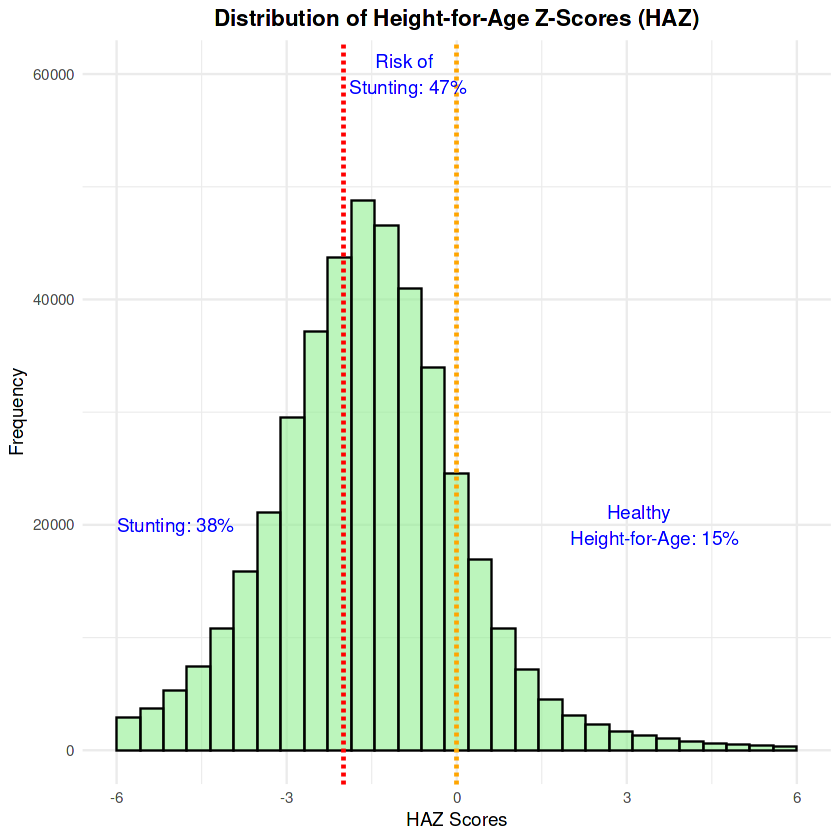

In [17]:
# First, categorize HAZ scores into nourishment categories
HAZ_Dta <- HAZ_Dta %>%
  mutate(HAZ_category = case_when(
    HAZ < -2 ~ "Stunting",
    HAZ >= -2 & HAZ <= 0 ~ "Risk of Stunting",
    HAZ > 0 ~ "Healthy Height-for-Age"
  )) 

# Calculate percentages for each HAZ category
category_percentage_HAZ <- HAZ_Dta %>%
  group_by(HAZ_category) %>%
  summarise(count = n()) %>%
  mutate(percentage = round(count / sum(count) * 100))
# View Category results
category_percentage_HAZ
# Plot histogram with percentage labels for each category
HAZ_plot <- ggplot(HAZ_Dta, aes(x = HAZ)) +
  geom_histogram(aes(y = after_stat(count)), bins = 30, fill = "lightgreen", color = "black", alpha = 0.6) +
  geom_vline(xintercept = -2, linetype = "dashed", color = "red", size = 1) +  
  geom_vline(xintercept = 0, linetype = "dashed", color = "orange", size = 1) +
  annotate("text", x = -6, y = 20000, label = "Stunting: 38%", color = "blue", hjust = 0) + 
  annotate("text", x = -1.9, y = 60000, label = "     Risk of\nStunting: 47%", color = "blue", hjust = 0) + 
  annotate("text", x = 2, y = 20000, label = "       Healthy\nHeight-for-Age: 15%", color = "blue", hjust = 0) + 
  labs(title = "Distribution of Height-for-Age Z-Scores (HAZ)",
       x = "HAZ Scores",
       y = "Frequency") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),  # Center the title
        plot.subtitle = element_text(hjust = 0.5))  # Center the subtitle

# Display the plot
HAZ_plot

WHZ_category              count  percentage
1 Healthy Weight-for-Height 195732 47        
2 Risk of Wasting           190007 45        
3 Wasting                    34956  8

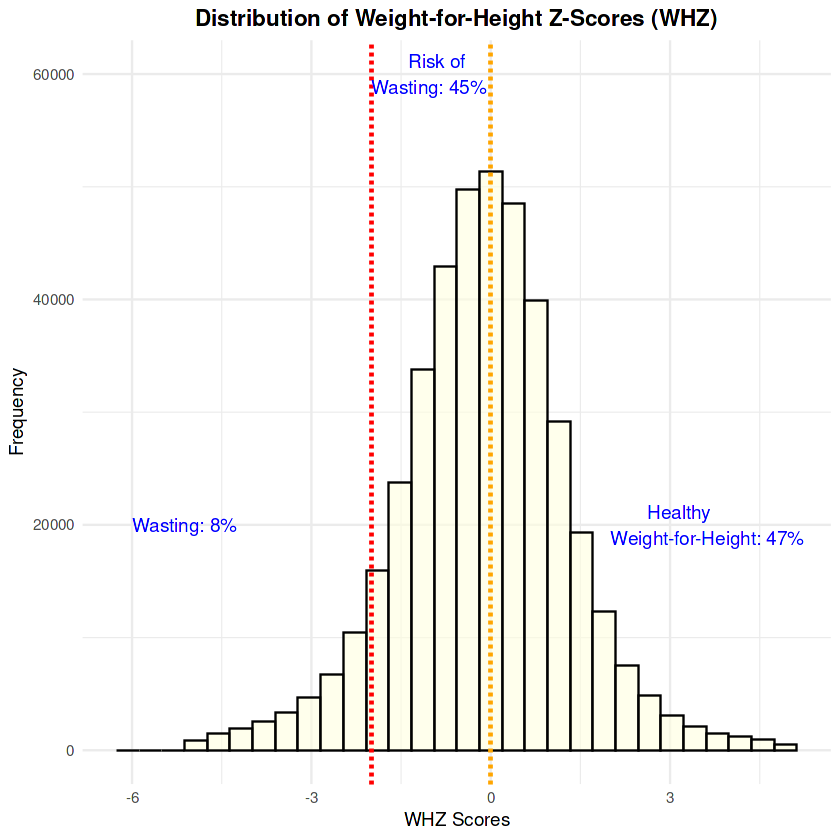

In [18]:
# First, categorize WHZ scores into nourishment categories
WHZ_Dta <- WHZ_Dta %>%
  mutate(WHZ_category = case_when(
    WHZ < -2 ~ "Wasting",
    WHZ >= -2 & WHZ <= 0 ~ "Risk of Wasting",
    WHZ > 0 ~ "Healthy Weight-for-Height"
  )) 

# Calculate percentages for each WHZ category
category_percentage_WHZ <- WHZ_Dta %>%
  group_by(WHZ_category) %>%
  summarise(count = n()) %>%
  mutate(percentage = round(count / sum(count) * 100))
# View Category results
category_percentage_WHZ
# Plot histogram with percentage labels for each category
WHZ_plot <- ggplot(WHZ_Dta, aes(x = WHZ)) +
  geom_histogram(aes(y = after_stat(count)), bins = 30, fill = "lightyellow", color = "black", alpha = 0.6) +
  geom_vline(xintercept = -2, linetype = "dashed", color = "red", size = 1) +  
  geom_vline(xintercept = 0, linetype = "dashed", color = "orange", size = 1) +
# Annotate the plot with a custom label
  annotate("text", x = -6, y = 20000, label = "Wasting: 8%", color = "blue", hjust = 0) + 
  annotate("text", x = -2, y = 60000, label = "       Risk of\nWasting: 45%", color = "blue", hjust = 0) + 
  annotate("text", x = 2, y = 20000, label = "       Healthy\nWeight-for-Height: 47%", color = "blue", hjust = 0) + 
  labs(title = "Distribution of Weight-for-Height Z-Scores (WHZ)",
       x = "WHZ Scores",
       y = "Frequency") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),  # Center the title
        plot.subtitle = element_text(hjust = 0.5))  # Center the subtitle

# Display the plot
WHZ_plot

## Distribution of Temperature Across Regions 

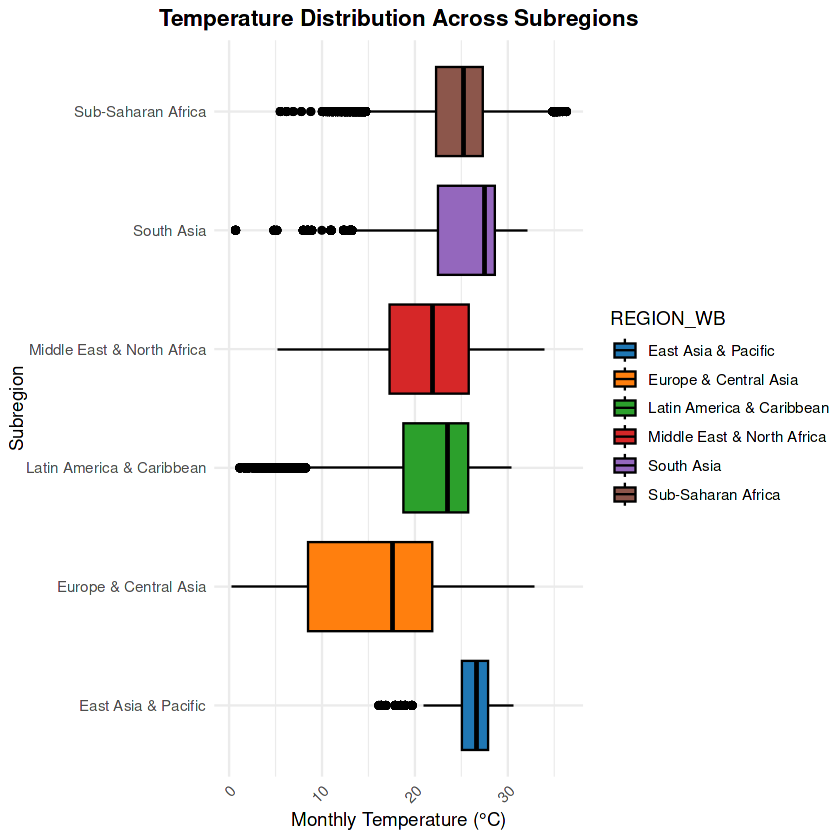

In [19]:
# Palette 
regions_palette <- c('#1F77B4','#FF7F0E','#2CA02C','#D62728','#9467BD','#8C564B','#E377C2',
                               '#7F7F7F','#BCBD22','#17BECF','#AEC7E8','#FFBB78','#98DF8A','#FF9896')
# Boxplot to show the temperature distribution across regions
ggplot(joined_data, aes(x = REGION_WB, y = Monthly_Temperature)) +
  geom_boxplot(aes(fill = REGION_WB), color = "black") +  

  scale_fill_manual(values =regions_palette )+
  coord_flip() +  
  labs(title = "Temperature Distribution Across Subregions",
       x = "Subregion",
       y = "Monthly Temperature (°C)") +
  theme_minimal() +  
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),  
        plot.subtitle = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 45, hjust = 1))  

`summarise()` has grouped output by 'REGION_WB'. You can override using the
`.groups` argument.


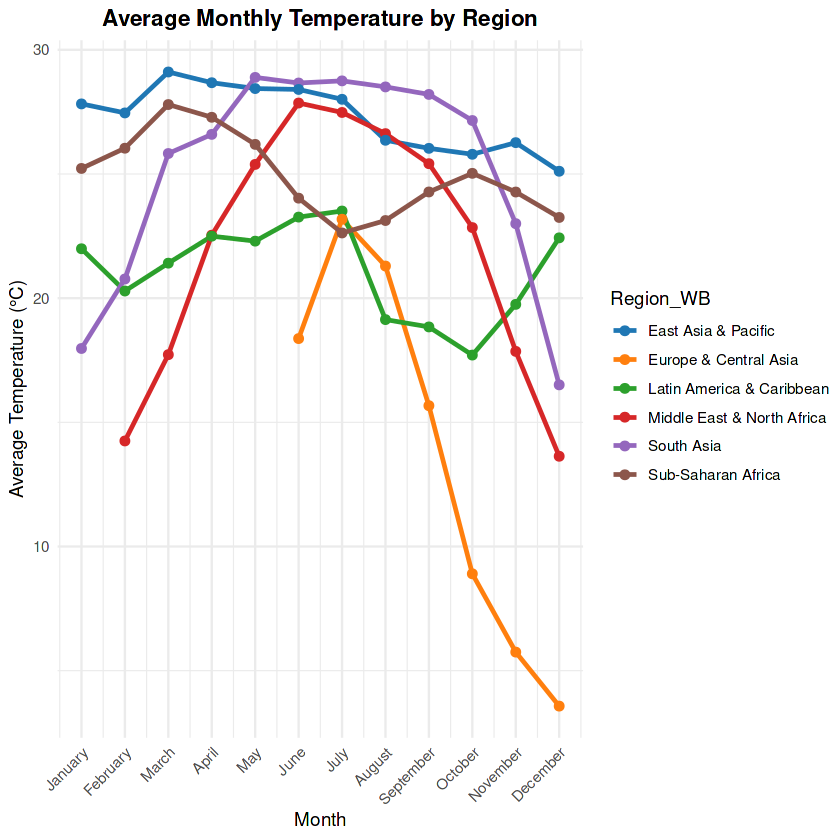

In [20]:
# Calculate average temperature by country and year
avg_temperature_by_region<- WAZ_Dta %>%
  group_by(REGION_WB,Month) %>%  # Group by both country
  summarise(Average_Temperature = mean(Monthly_Temperature)) %>% 
arrange(desc(Average_Temperature))

ggplot(avg_temperature_by_region, aes(x = Month, y = Average_Temperature, color = REGION_WB, group = REGION_WB)) +
  geom_line(size = 1) +  # Line plot with different subregions
  geom_point(size = 2) +  # Add points to the line plot
  labs(title = "Average Monthly Temperature by Region",
       x = "Month",
       y = "Average Temperature (°C)",
       color = "Region_WB") +
  
  scale_x_continuous(breaks = 1:12, labels = month.name) +  # Add a + before theme_minimal()
  scale_color_manual(values = regions_palette) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1))

## Socio-Economic Indicators

In [21]:
# Calculate percentage of children in rural and urban areas
summary_area <- joined_data %>%
  group_by(Rural) %>%
  summarise(count = n()) %>%
  mutate(percentage_Rural = count / sum(count) * 100)

# Calculate percentage of children Female and Male 
summary_gender <- joined_data %>%
  group_by(Female) %>%
  summarise(count = n()) %>%
  mutate(percentage_Female = count / sum(count) * 100)

# Calculate percentage of children Improved and Unimproved water source
summary_w_source <- joined_data %>%
  group_by(Water_source_unimproved) %>%
  summarise(count = n()) %>%
  mutate(percentage_water_source = count / sum(count) * 100)

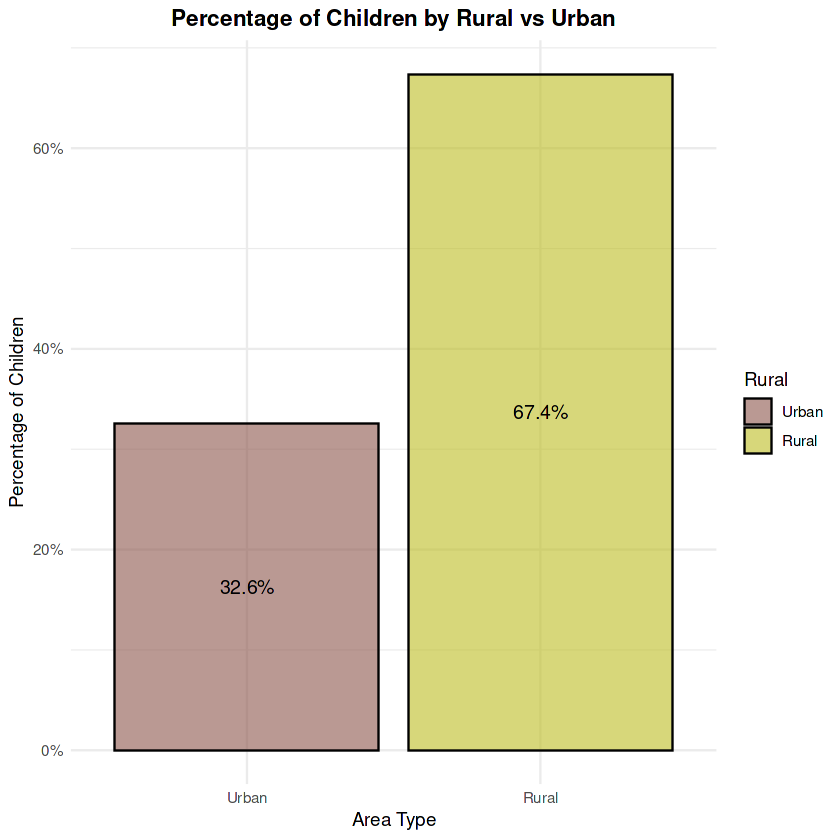

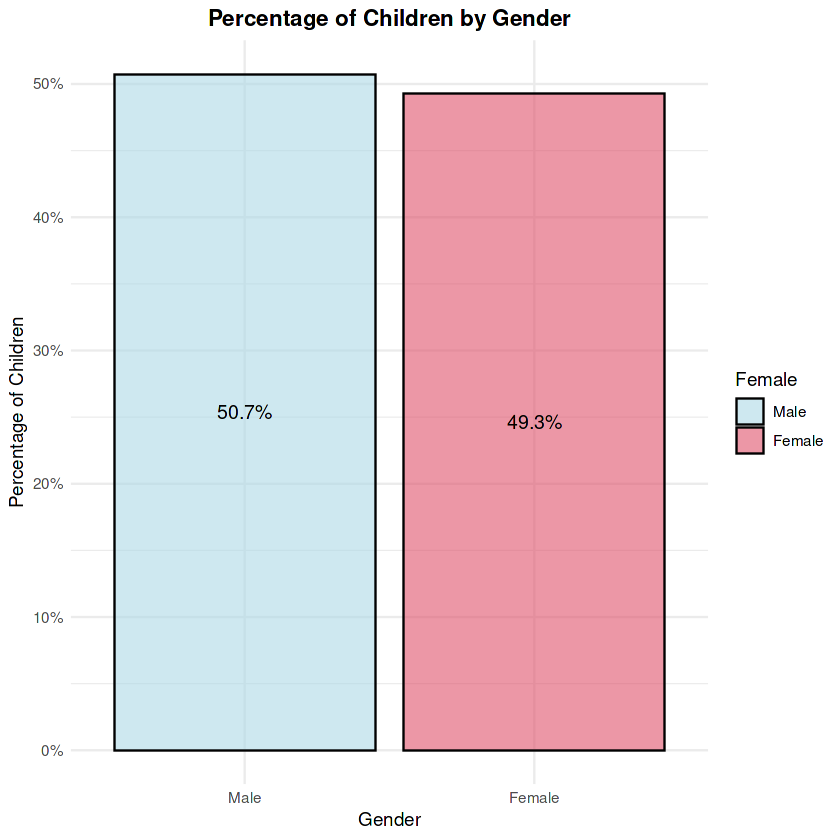

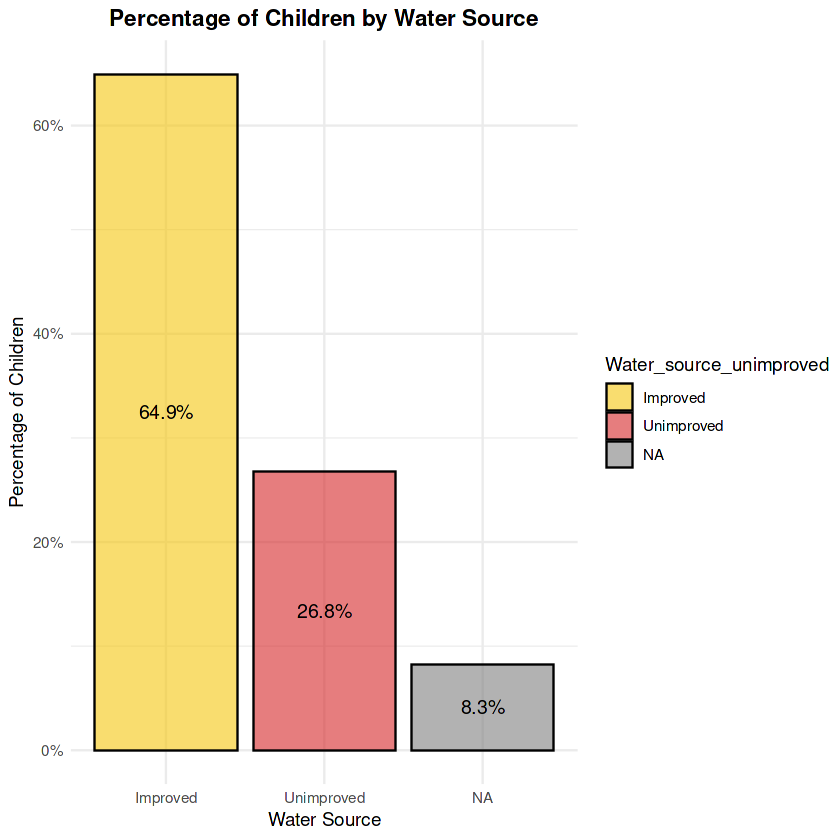

In [22]:
# Create the plot for Rural vs Urban in percentages
Rural_Urban_Plot <- ggplot(summary_area, aes(x = Rural, y = percentage_Rural, fill = Rural)) +
  geom_bar(stat = "identity", color = "black", alpha = 0.6) +  
  labs(title = "Percentage of Children by Rural vs Urban",
       x = "Area Type",
       y = "Percentage of Children") +
  geom_text(aes(label = paste0(round(percentage_Rural, 1), "%")), 
            position = position_stack(vjust = 0.5), color = "black", size = 4) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +  
  scale_fill_manual(values = c("Urban" = "#8C564B", "Rural" = "#BCBD22"))
# Display the plot
Rural_Urban_Plot

# Create the plot for Gender in percentages
Female_Male_Plot <- ggplot(summary_gender, aes(x = Female, y = percentage_Female, fill = Female)) +
  geom_bar(stat = "identity", color = "black", alpha = 0.6) + 
  labs(title = "Percentage of Children by Gender",
       x = "Gender",
       y = "Percentage of Children") +
  geom_text(aes(label = paste0(round(percentage_Female, 1), "%")), 
            position = position_stack(vjust = 0.5), color = "black", size = 4) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +  
  scale_fill_manual(values = c("Male" = "lightblue", "Female" = "98DF8A"))

# Display the plot
Female_Male_Plot

# Create the plot for Water Source in percentages
water_Plot <- ggplot(summary_w_source, aes(x = Water_source_unimproved, y = percentage_water_source, fill = Water_source_unimproved)) +
  geom_bar(stat = "identity", color = "black", alpha = 0.6) +  
  labs(title = "Percentage of Children by Water Source",
       x = "Water Source",
       y = "Percentage of Children") +
  geom_text(aes(label = paste0(round(percentage_water_source, 1), "%")), 
            position = position_stack(vjust = 0.5), color = "black", size = 4) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +  
  scale_fill_manual(values = c("Improved" = "7F7F7F", "Unimproved" = "#D62728"))
# Display the plot
water_Plot

## Impact of Temperature on Child Nutrition

In [23]:
# Count the number of observations in each region
Filter_region_WAZ <- WAZ_Dta %>% 
  group_by(REGION_WB, Monthly_Temperature) %>%
  group_by(Adm_Region)%>%
  mutate(num_obs = n(),  
            avg_WAZ = mean(WAZ, na.rm = TRUE),  
            avg_Monthly_Temperature = mean(Monthly_Temperature))
# Count the number of observations in each region
Filter_region_HAZ <- HAZ_Dta %>% 
  group_by(REGION_WB, Monthly_Temperature) %>%
  group_by(Adm_Region)%>%
  mutate(num_obs = n(),  
            avg_HAZ = mean(HAZ, na.rm = TRUE), 
            avg_Monthly_Temperature = mean(Monthly_Temperature))
# Count the number of observations in each region
Filter_region_WHZ <- WHZ_Dta %>% 
  group_by(REGION_WB, Monthly_Temperature) %>%
  group_by(Adm_Region)%>%
  mutate(num_obs = n(),  
            avg_WHZ = mean(WHZ, na.rm = TRUE),  
            avg_Monthly_Temperature = mean(Monthly_Temperature))

`geom_smooth()` using formula = 'y ~ x'


NULL

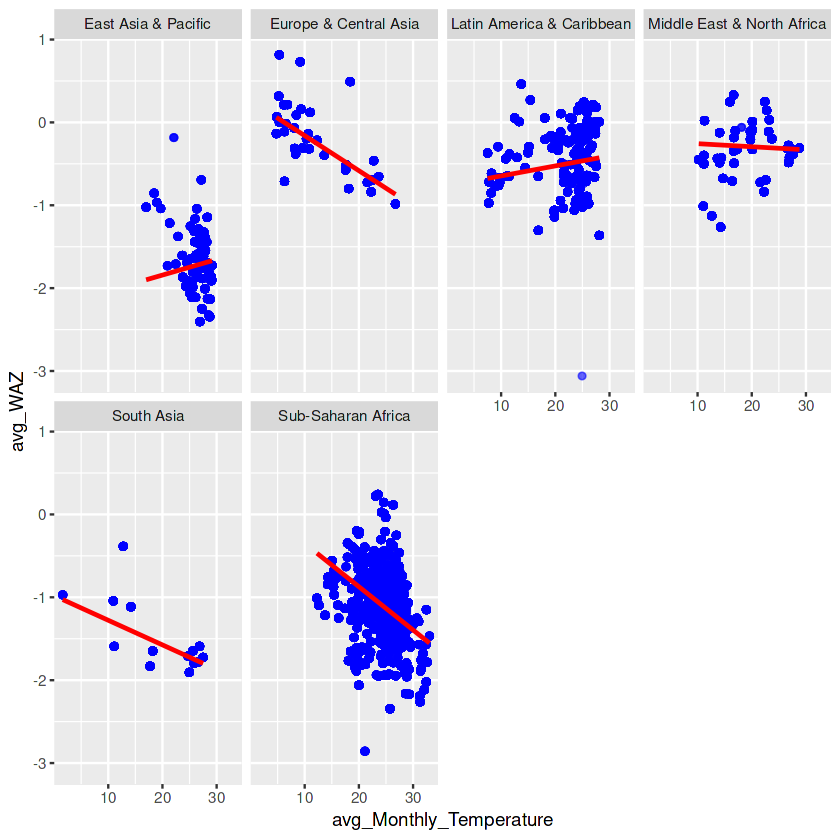

In [24]:
# Scatter plot of avg WAZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_WAZ, aes(x = avg_Monthly_Temperature, y = avg_WAZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ REGION_WB, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

`geom_smooth()` using formula = 'y ~ x'


NULL

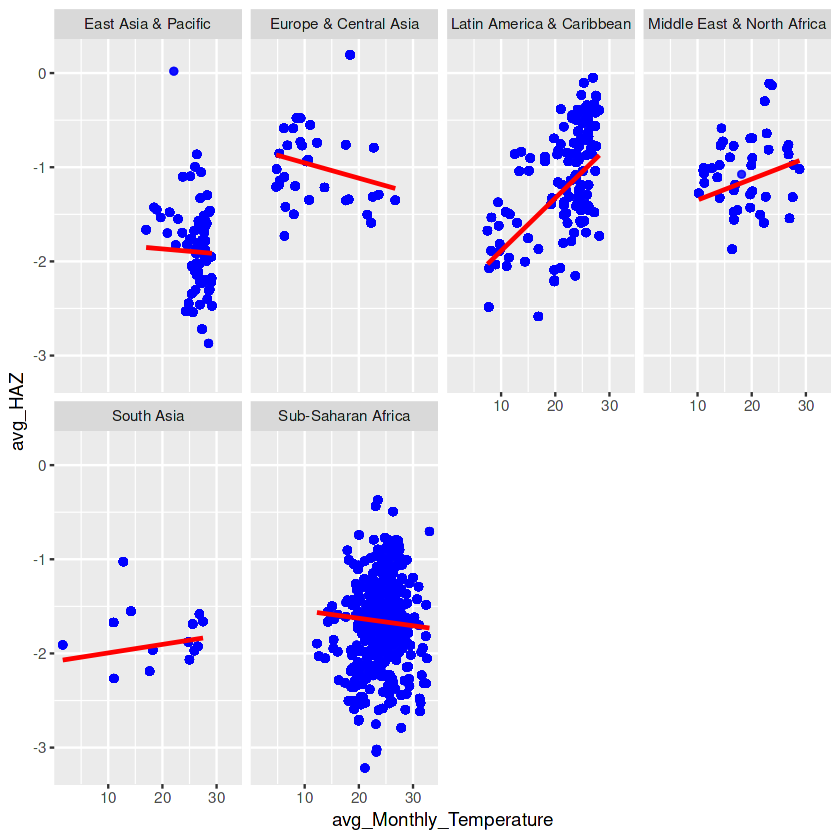

In [25]:
# Scatter plot of avg WAZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_HAZ, aes(x = avg_Monthly_Temperature, y = avg_HAZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ REGION_WB, ncol = 4) 
  labs(title = 'Scatter Plot of HAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "HAZ (Height-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

`geom_smooth()` using formula = 'y ~ x'


NULL

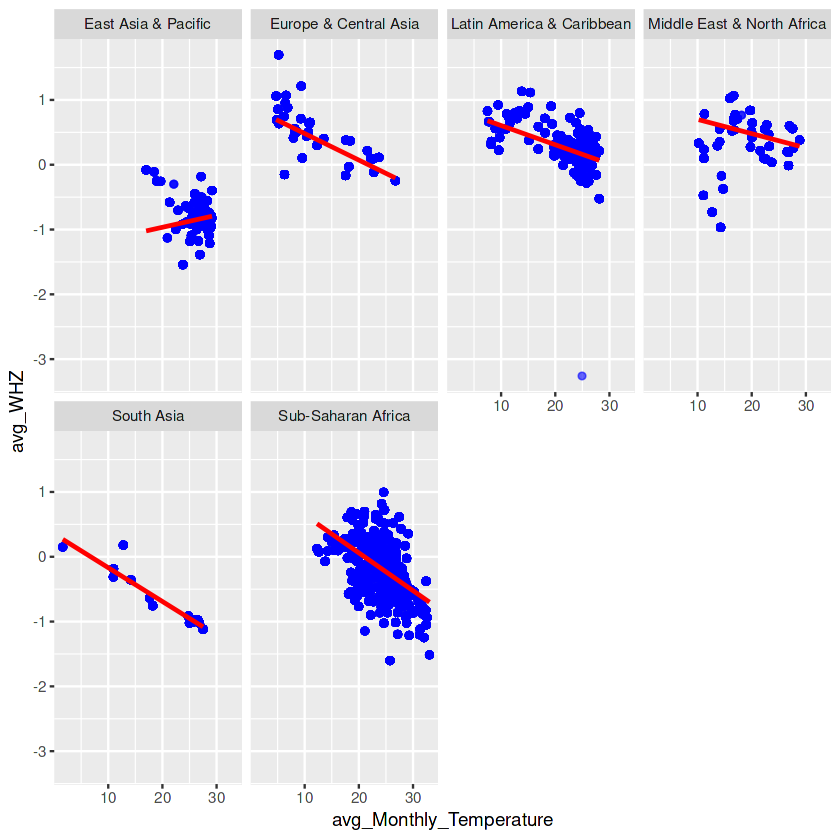

In [26]:
# Scatter plot of avg WAZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_WHZ, aes(x = avg_Monthly_Temperature, y = avg_WHZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ REGION_WB, ncol = 4) 
  labs(title = 'Scatter Plot of WHZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WHZ (Weight-for-Height Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# 5. Modeling
This phase involves building and refining statistical models to uncover relationships between variables in the dataset.

## Temperature Effects on anthropometric outcomes on children with fixed effects. 

We employ models that control for key fixed effects, including time (Year, Month) and location (Country), while clustering standard errors at the Region_id level to account for potential intra-regional correlations. This approach allows us to better isolate the effects of temperature variations on child growth, controlling for unobserved heterogeneity and other environmental or contextual factors, thus providing a more accurate understanding of how climate conditions influence child nutrition and development.

In [27]:
#Models 
model1 <- feols(WAZ ~ Monthly_Temperature | Year + Month + Country, data = WAZ_Dta, cluster = ~Region_id)
model2 <- feols(HAZ ~ Monthly_Temperature | Year + Month + Country, data = HAZ_Dta, cluster = ~Region_id)
model3 <- feols(WHZ ~ Monthly_Temperature | Year + Month + Country, data = WHZ_Dta, cluster = ~Region_id)

options(modelsummary_factory_default = 'kableExtra')
options(modelsummary_factory_latex = 'kableExtra')
options(modelsummary_factory_html = 'kableExtra')
# Create a regression table
modelsummary(list("Model 1 WAZ" = model1, 
                  "Model 2 HAZ" = model2, 
                  "Model 3 WHZ" = model3), 
             output = "markdown", 
             stars = TRUE)  


+---------------------+---------------+---------------+---------------+
|                     | Model 1 WAZ   | Model 2 HAZ   | Model 3 WHZ   |
+=====================+===============+===============+===============+
| Monthly_Temperature | -0.021***     | 0.001         | -0.029***     |
+---------------------+---------------+---------------+---------------+
|                     | (0.004)       | (0.006)       | (0.002)       |
+---------------------+---------------+---------------+---------------+
| Num.Obs.            | 432631        | 423706        | 420695        |
+---------------------+---------------+---------------+---------------+
| R2                  | 0.148         | 0.070         | 0.112         |
+---------------------+---------------+---------------+---------------+
| R2 Adj.             | 0.148         | 0.070         | 0.112         |
+---------------------+---------------+---------------+---------------+
| R2 Within           | 0.002         | 0.000         | 0.004  

## Temperature Effects on Anthropometric Outcomes in Children: Comparison of Models with child controls and Fixed Effects. 

This analysis examines how temperature variations impact children’s anthropometric outcomes. The models include child-specific controls like rural residence, age in months, gender, and birth order, along with fixed effects for time (Year, Month) and location (Country), and clustering standard errors at the Region_id level.

In [28]:
#Models 
model4 <- feols(WAZ ~ Monthly_Temperature + Rural + Age_in_months + Female + Birth_order | Year + Month + Country, data = WAZ_Dta, cluster = ~Region_id)
model5 <- feols(HAZ ~ Monthly_Temperature + Rural + Age_in_months + Female + Birth_order | Year + Month + Country, data = HAZ_Dta, cluster = ~Region_id)
model6 <- feols(WHZ ~ Monthly_Temperature + Rural + Age_in_months + Female + Birth_order | Year + Month + Country, data = WHZ_Dta, cluster = ~Region_id)


# Create a regression table
modelsummary(list("Model 4 WAZ" = model4, 
                  "Model 5 HAZ" = model5, 
                  "Model 6 WHZ" = model6), 
             output = "markdown", 
             stars = TRUE)  


+---------------------+---------------+---------------+---------------+
|                     | Model 4 WAZ   | Model 5 HAZ   | Model 6 WHZ   |
+=====================+===============+===============+===============+
| Monthly_Temperature | -0.020***     | 0.002         | -0.028***     |
+---------------------+---------------+---------------+---------------+
|                     | (0.004)       | (0.005)       | (0.002)       |
+---------------------+---------------+---------------+---------------+
| RuralRural          | -0.322***     | -0.450***     | -0.061***     |
+---------------------+---------------+---------------+---------------+
|                     | (0.025)       | (0.037)       | (0.017)       |
+---------------------+---------------+---------------+---------------+
| Age_in_months       | -0.003***     | -0.006***     | 0.007***      |
+---------------------+---------------+---------------+---------------+
|                     | (0.000)       | (0.001)       | (0.001)

## Temperature Effects on Anthropometric Outcomes in Children: Comparison of Models with Maternal Controls and Fixed Effects.

The models control for key maternal factors such as Mother’s age, marital status (Married), and the total number of children (Total_children). Additionally, fixed effects for time (Year, Month) and location (Country) are applied to account for unobserved heterogeneity, providing a more robust understanding of how temperature fluctuations impact child growth outcomes

In [29]:
#Models 
model7 <- feols(WAZ ~ Monthly_Temperature + Mothers_age + Married  + Total_children | Year + Month + Country, data = WAZ_Dta, cluster = ~Region_id)
model8 <- feols(HAZ ~ Monthly_Temperature + Mothers_age + Married  + Total_children | Year + Month + Country, data = HAZ_Dta, cluster = ~Region_id)
model9 <- feols(WHZ ~ Monthly_Temperature + Mothers_age + Married  + Total_children | Year + Month + Country, data = WHZ_Dta, cluster = ~Region_id)


# Create a regression table
modelsummary(list("Model 7 WAZ" = model7, 
                  "Model 8 HAZ" = model8, 
                  "Model 9 WHZ" = model9), 
             output = "markdown", 
             stars = TRUE)  

NOTE: 1 observation removed because of NA values (RHS: 1).



NOTE: 1 observation removed because of NA values (RHS: 1).



NOTE: 1 observation removed because of NA values (RHS: 1).




+---------------------+---------------+---------------+---------------+
|                     | Model 7 WAZ   | Model 8 HAZ   | Model 9 WHZ   |
+=====================+===============+===============+===============+
| Monthly_Temperature | -0.019***     | 0.003         | -0.028***     |
+---------------------+---------------+---------------+---------------+
|                     | (0.004)       | (0.005)       | (0.002)       |
+---------------------+---------------+---------------+---------------+
| Mothers_age         | 0.023***      | 0.033***      | 0.005***      |
+---------------------+---------------+---------------+---------------+
|                     | (0.002)       | (0.002)       | (0.001)       |
+---------------------+---------------+---------------+---------------+
| Married             | -0.003        | 0.019         | 0.004         |
+---------------------+---------------+---------------+---------------+
|                     | (0.017)       | (0.019)       | (0.010)

## Temperature Effects on Anthropometric Outcomes in Children: Comparison of Models with Water Source Controls. 
The models include controls for access to water sources, specifically distinguishing between unimproved and improved water sources (Water_source_unimproved). This control helps to isolate the impact of water quality on child growth outcomes, while also accounting for fixed effects related to time (Year, Month) and location (Country). This approach aims to provide a clearer understanding of how both temperature fluctuations and water source access influence children’s anthropometric outcomes.

In [30]:
#Models 
model10 <- feols(WAZ ~ Monthly_Temperature  + Water_source_unimproved  | Year + Month + Country, data = WAZ_Dta, cluster = ~Region_id)
model11 <- feols(HAZ ~ Monthly_Temperature  + Water_source_unimproved  | Year + Month + Country, data = HAZ_Dta, cluster = ~Region_id)
model12 <- feols(WHZ ~ Monthly_Temperature  + Water_source_unimproved  | Year + Month + Country, data = WHZ_Dta, cluster = ~Region_id)


# Create a regression table
modelsummary(list("Model 10 WAZ" = model10, 
                  "Model 11 HAZ" = model11, 
                  "Model 12 WHZ" = model12), 
             output = "markdown", 
             stars = TRUE)  

NOTE: 36,003 observations removed because of NA values (RHS: 36,003).



NOTE: 35,441 observations removed because of NA values (RHS: 35,441).



NOTE: 35,402 observations removed because of NA values (RHS: 35,402).




+-----------------------------------+---------------+---------------+---------------+
|                                   | Model 10 WAZ  | Model 11 HAZ  | Model 12 WHZ  |
+===================================+===============+===============+===============+
| Monthly_Temperature               | -0.021***     | 0.000         | -0.029***     |
+-----------------------------------+---------------+---------------+---------------+
|                                   | (0.004)       | (0.006)       | (0.003)       |
+-----------------------------------+---------------+---------------+---------------+
| Water_source_unimprovedUnimproved | -0.149***     | -0.202***     | -0.022+       |
+-----------------------------------+---------------+---------------+---------------+
|                                   | (0.016)       | (0.022)       | (0.013)       |
+-----------------------------------+---------------+---------------+---------------+
| Num.Obs.                          | 396628        |

## Temperature Effects on Anthropometric Outcomes in Children: Comparison Rural VS Urban Areas

`geom_smooth()` using formula = 'y ~ x'


NULL

`geom_smooth()` using formula = 'y ~ x'


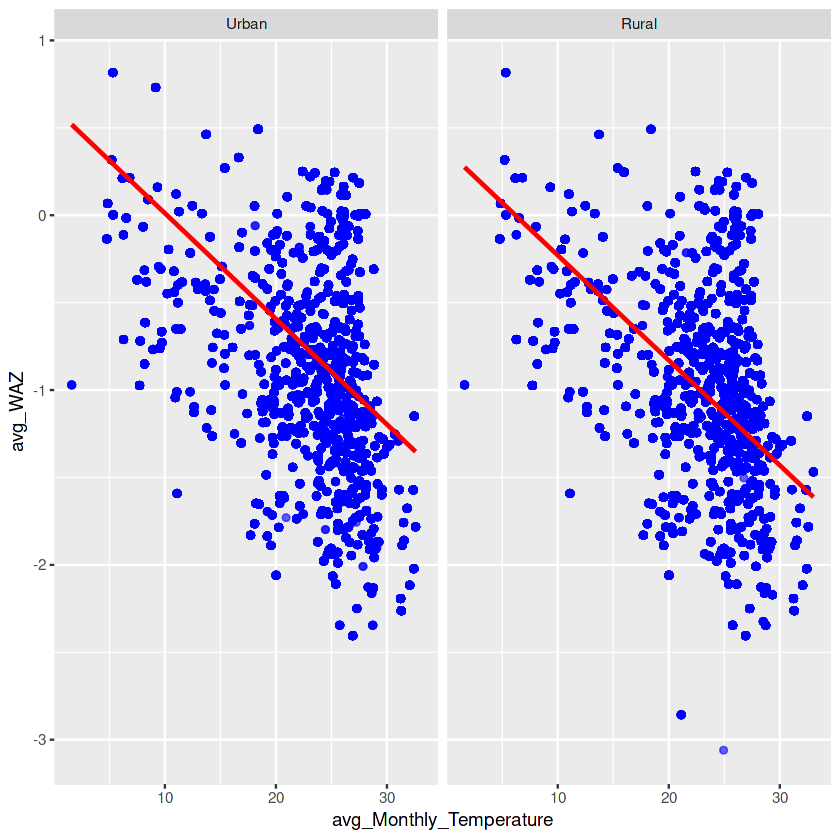

NULL

`geom_smooth()` using formula = 'y ~ x'


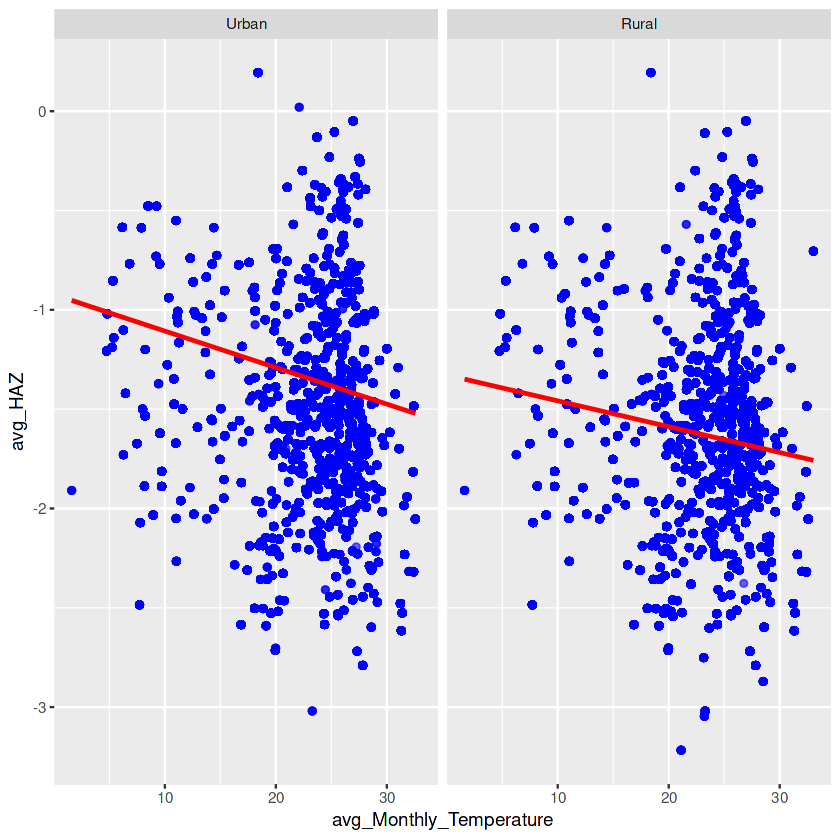

NULL

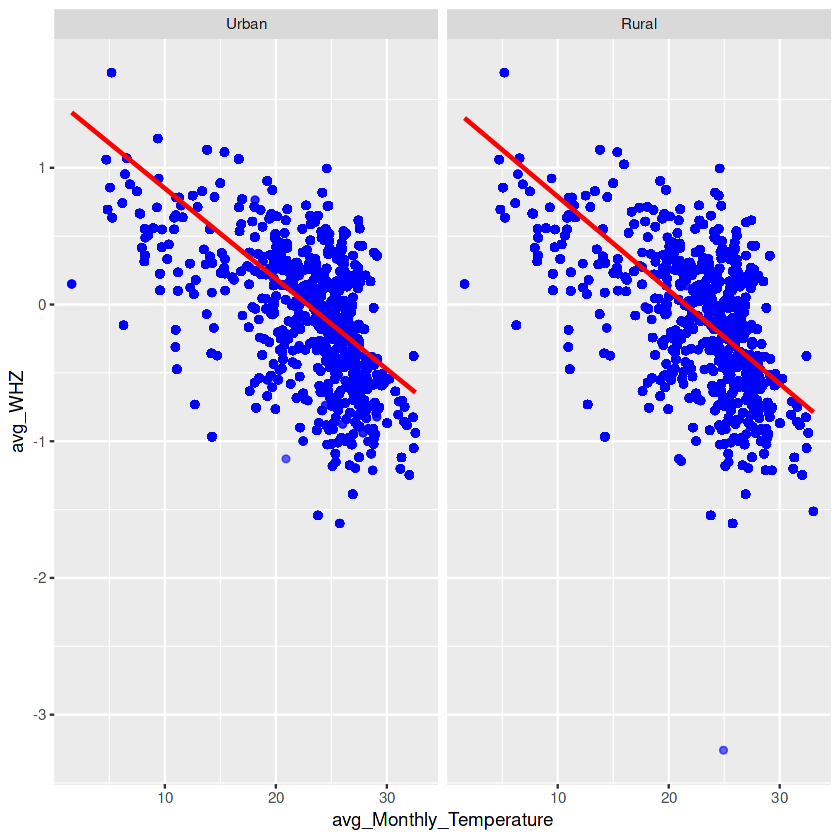

In [31]:
# Scatter plot of avg WAZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_WAZ, aes(x = avg_Monthly_Temperature, y = avg_WAZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ Rural, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# Scatter plot of avg HAZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_HAZ, aes(x = avg_Monthly_Temperature, y = avg_HAZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ Rural, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# Scatter plot of avg WHZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_WHZ, aes(x = avg_Monthly_Temperature, y = avg_WHZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ Rural, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))


## Temperature Effects on Anthropometric Outcomes in Children:Gender Comparison 

`geom_smooth()` using formula = 'y ~ x'


NULL

`geom_smooth()` using formula = 'y ~ x'


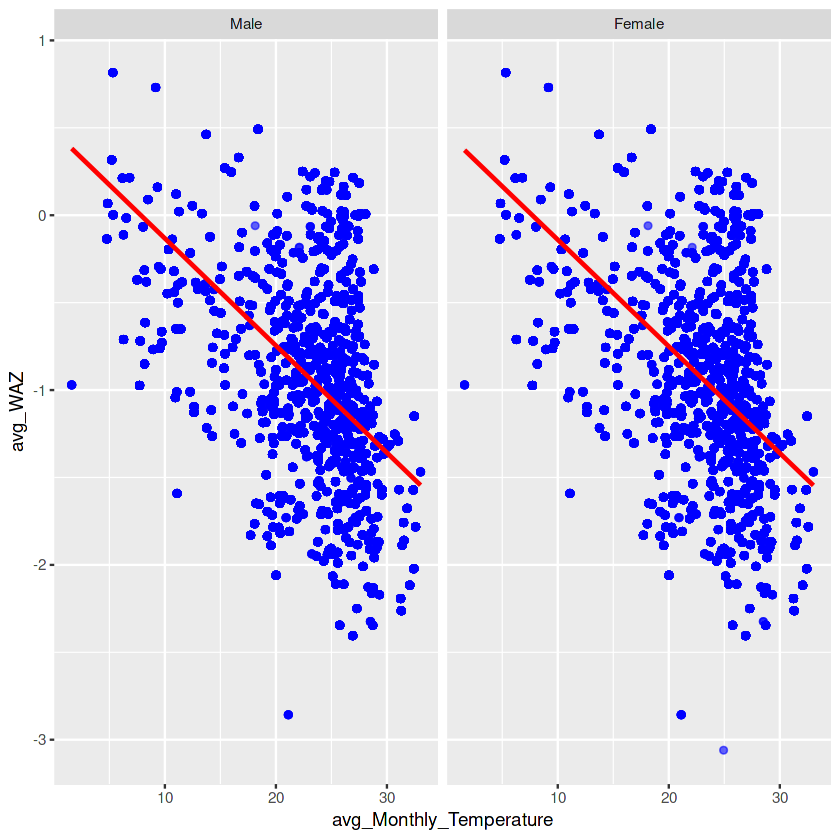

NULL

`geom_smooth()` using formula = 'y ~ x'


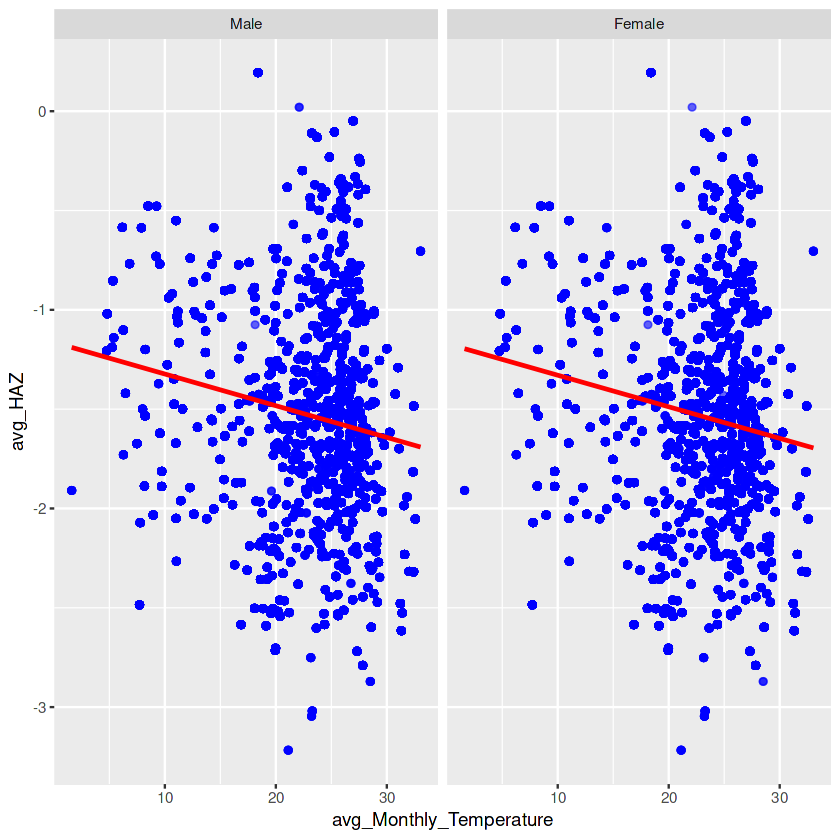

NULL

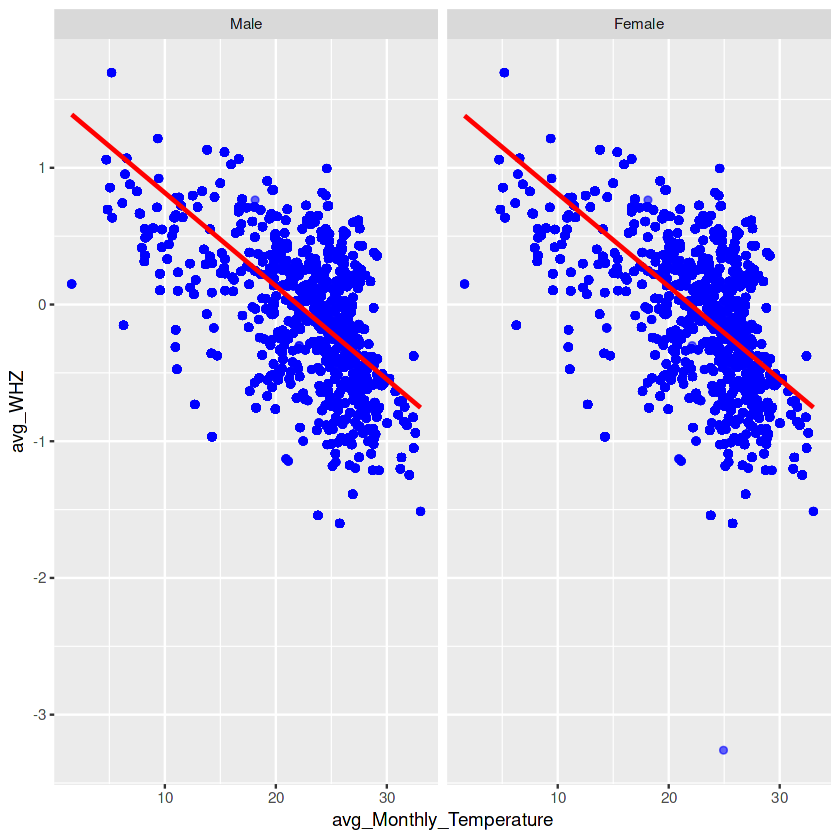

In [32]:
# Scatter plot of avg WAZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_WAZ, aes(x = avg_Monthly_Temperature, y = avg_WAZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ Female, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# Scatter plot of avg HAZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_HAZ, aes(x = avg_Monthly_Temperature, y = avg_HAZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ Female, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# Scatter plot of avg WHZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_WHZ, aes(x = avg_Monthly_Temperature, y = avg_WHZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ Female, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

## Temperature Effects on Anthropometric Outcomes in Children:Water Source Improvement Comparison 

`geom_smooth()` using formula = 'y ~ x'


NULL

`geom_smooth()` using formula = 'y ~ x'


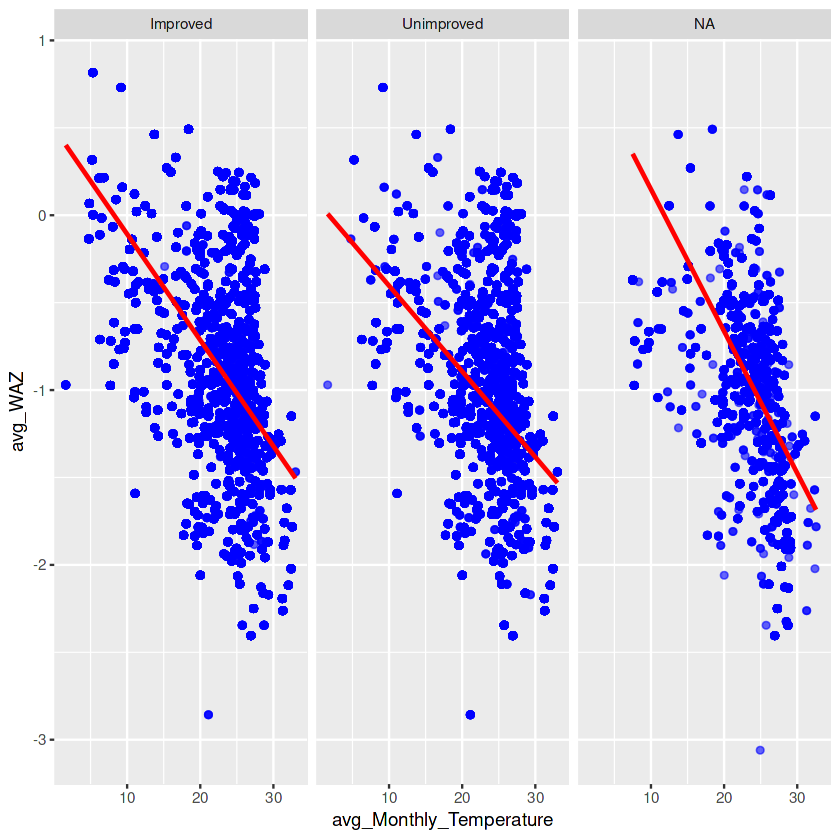

NULL

`geom_smooth()` using formula = 'y ~ x'


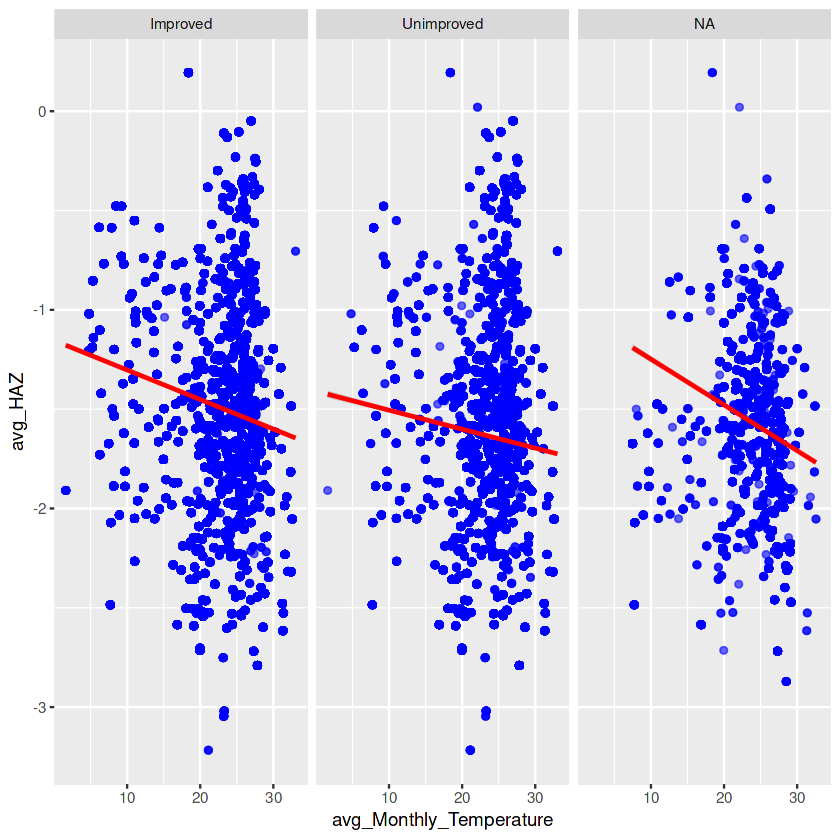

NULL

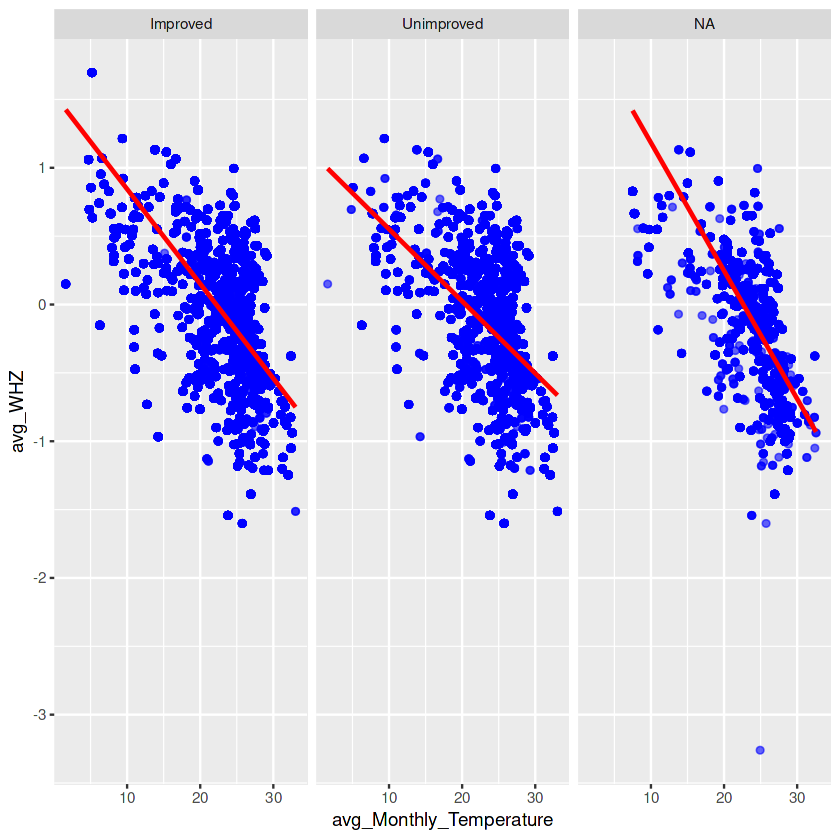

In [33]:
# Scatter plot of avg WAZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_WAZ, aes(x = avg_Monthly_Temperature, y = avg_WAZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ Water_source_unimproved, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# Scatter plot of avg HAZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_HAZ, aes(x = avg_Monthly_Temperature, y = avg_HAZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ Water_source_unimproved, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# Scatter plot of avg WHZ vs. avg Monthly Temperature, weighted by number of observations
ggplot(Filter_region_WHZ, aes(x = avg_Monthly_Temperature, y = avg_WHZ)) +
  geom_point(color = "blue", alpha = 0.6) +  # Points sized by number of observations
  geom_smooth(method = "lm", color = "red", se = TRUE) +  # Polynomial regression line
  facet_wrap(~ Water_source_unimproved, ncol = 4) 
  labs(title = 'Scatter Plot of WAZ vs. Monthly Temperature \n (Weighted by Number of Observations)',
       x = "Monthly Temperature (°C)",
       y = "WAZ (Weight-for-Age Z-score)",
       size = "Number of Observations") +  # Add legend for point size
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# 6. Regional and Cultural Variations

## Anthropometrics by Regions: Organizing Dataframes by Regions

To analyze anthropometric outcomes by region, we will organize the dataframes based on the regions defined in the dataset. By grouping the data by regions such as Sub-Saharan Africa, Latin America & the Caribbean, South Asia, and others, we can better understand how anthropometric indicators vary across different geographical contexts. This approach allows for targeted insights into regional disparities in child growth and nutrition, taking into account both environmental and socio-economic factors.

In [34]:
Sub_Saharan_Africa_WAZ <- WAZ_Dta %>% filter(WAZ_Dta$REGION_WB == 'Sub-Saharan Africa')
Latin_America_Caribbean_WAZ <- WAZ_Dta %>% filter(WAZ_Dta$REGION_WB =='Latin America & Caribbean')
East_Asia_Pacific_WAZ <- WAZ_Dta %>% filter(WAZ_Dta$REGION_WB == 'East Asia & Pacific')
South_Asia_WAZ <- WAZ_Dta %>% filter(WAZ_Dta$REGION_WB == 'South Asia')
Middle_East_North_Africa_WAZ <- WAZ_Dta %>% filter(WAZ_Dta$REGION_WB == 'Middle East & North Africa')
Europe_Central_Asia_WAZ <- WAZ_Dta %>% filter(WAZ_Dta$REGION_WB == 'Europe & Central Asia')


Sub_Saharan_Africa_HAZ <- HAZ_Dta %>% filter(HAZ_Dta$REGION_WB == 'Sub-Saharan Africa')
Latin_America_Caribbean_HAZ <- HAZ_Dta %>% filter(HAZ_Dta$REGION_WB =='Latin America & Caribbean')
East_Asia_Pacific_HAZ <- HAZ_Dta %>% filter(HAZ_Dta$REGION_WB == 'East Asia & Pacific')
South_Asia_HAZ <- HAZ_Dta %>% filter(HAZ_Dta$REGION_WB == 'South Asia')
Middle_East_North_Africa_HAZ <- HAZ_Dta %>% filter(HAZ_Dta$REGION_WB == 'Middle East & North Africa')
Europe_Central_Asia_HAZ <- HAZ_Dta %>% filter(HAZ_Dta$REGION_WB == 'Europe & Central Asia')

Sub_Saharan_Africa_WHZ <- WHZ_Dta %>% filter(WHZ_Dta$REGION_WB == 'Sub-Saharan Africa')
Latin_America_Caribbean_WHZ <- WHZ_Dta %>% filter(WHZ_Dta$REGION_WB =='Latin America & Caribbean')
East_Asia_Pacific_WHZ <- WHZ_Dta %>% filter(WHZ_Dta$REGION_WB == 'East Asia & Pacific')
South_Asia_WHZ <- WHZ_Dta %>% filter(WHZ_Dta$REGION_WB == 'South Asia')
Middle_East_North_Africa_WHZ <- WHZ_Dta %>% filter(WHZ_Dta$REGION_WB == 'Middle East & North Africa')
Europe_Central_Asia_WHZ <- WHZ_Dta %>% filter(WHZ_Dta$REGION_WB == 'Europe & Central Asia')


## Temperature Effects on Anthropometric Outcomes in Children: Comparison of Models (WAZ by Regions)

This section of the analysis investigates how monthly temperature influences Weight-for-Age Z-scores (WAZ), a critical indicator of child nutrition and growth, across different world regions.
 

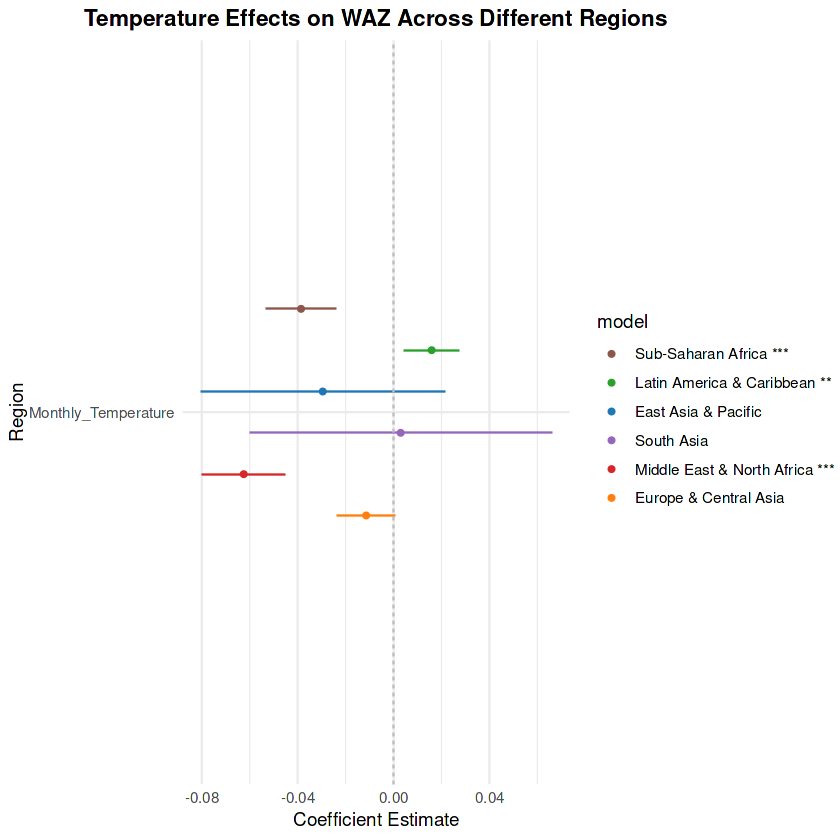

In [35]:
#Models 
model13 <- feols(WAZ ~ Monthly_Temperature | Year + Month + Country, data = Sub_Saharan_Africa_WAZ, cluster = ~Region_id)
model14 <- feols(WAZ ~ Monthly_Temperature | Year + Month + Country, data = Latin_America_Caribbean_WAZ, cluster = ~Region_id)
model15 <- feols(WAZ ~ Monthly_Temperature | Year + Month + Country, data = East_Asia_Pacific_WAZ, cluster = ~Region_id)
model16 <- feols(WAZ ~ Monthly_Temperature | Year + Month + Country, data = South_Asia_WAZ, cluster = ~Region_id)
model17 <- feols(WAZ ~ Monthly_Temperature | Year + Month + Country, data = Middle_East_North_Africa_WAZ, cluster = ~Region_id)
model18 <- feols(WAZ ~ Monthly_Temperature | Year + Month + Country, data = Europe_Central_Asia_WAZ, cluster = ~Region_id)

# Create a named list of models
model_list <- list(
  "Sub-Saharan Africa ***" = model13,
  "Latin America & Caribbean **" = model14,
  "East Asia & Pacific" = model15,
  "South Asia" = model16,
  "Middle East & North Africa ***" = model17,
  "Europe & Central Asia" = model18)

# Create the dot-whisker plot with model labels 
dwplot(model_list) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  labs(title = "Temperature Effects on WAZ Across Different Regions",
       x = "Coefficient Estimate",
       y = "Region") +
  # Apply custom colors for each region using scale_color_manual
  scale_color_manual(values = c("East Asia & Pacific" = "#1F77B4", 
                                "Europe & Central Asia" = "#FF7F0E",
                                "Latin America & Caribbean **" = "#2CA02C", 
                                "Middle East & North Africa ***" = "#D62728",
                                "South Asia" = "#9467BD",
                                "Sub-Saharan Africa ***" = "#8C564B" )) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

## Temperature Effects on Anthropometric Outcomes in Children: Comparison of Models (HAZ by Regions)

This section of the analysis investigates how monthly temperature influences Height-for-Age Z-scores (HAZ), a critical indicator of child nutrition and growth, across different world regions.
 

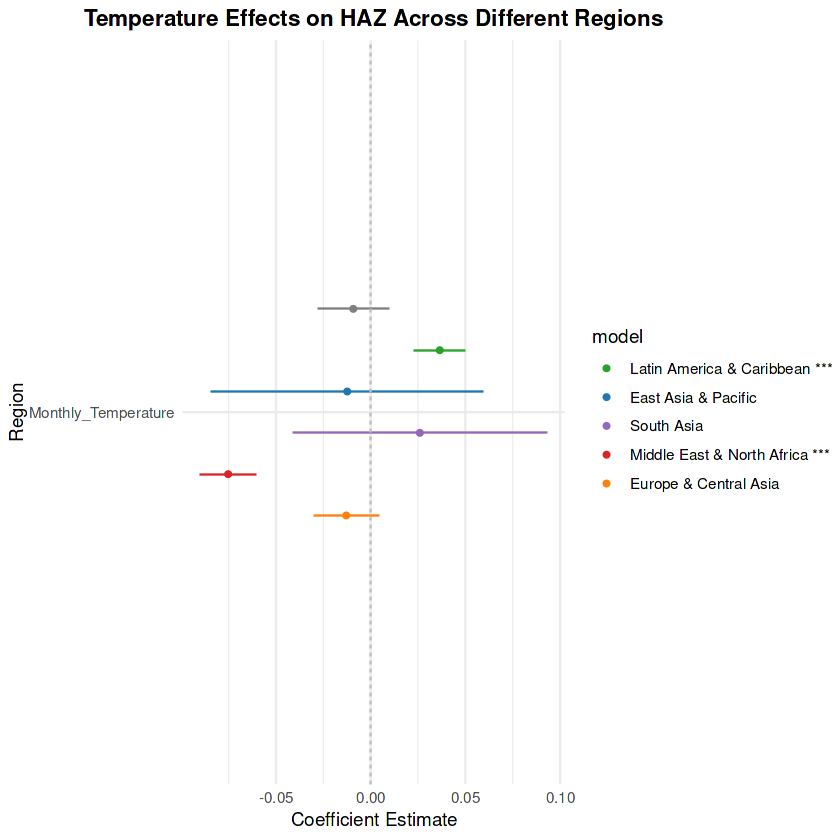

In [36]:
#Models 
model19 <- feols(HAZ ~ Monthly_Temperature | Year + Month + Country, data = Sub_Saharan_Africa_HAZ, cluster = ~Region_id)
model20 <- feols(HAZ ~ Monthly_Temperature | Year + Month + Country, data = Latin_America_Caribbean_HAZ, cluster = ~Region_id)
model21 <- feols(HAZ ~ Monthly_Temperature | Year + Month + Country, data = East_Asia_Pacific_HAZ, cluster = ~Region_id)
model22 <- feols(HAZ ~ Monthly_Temperature | Year + Month + Country, data = South_Asia_HAZ, cluster = ~Region_id)
model23 <- feols(HAZ ~ Monthly_Temperature | Year + Month + Country, data = Middle_East_North_Africa_HAZ, cluster = ~Region_id)
model24 <- feols(HAZ ~ Monthly_Temperature | Year + Month + Country, data = Europe_Central_Asia_HAZ, cluster = ~Region_id)

# Create a named list of models
model_list <- list(
  "Sub-Saharan Africa" = model19,
  "Latin America & Caribbean ***" = model20,
  "East Asia & Pacific" = model21,
  "South Asia" = model22,
  "Middle East & North Africa ***" = model23,
  "Europe & Central Asia" = model24)

# Create the dot-whisker plot with model labels and color-coded significance stars
dwplot(model_list) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  labs(title = "Temperature Effects on HAZ Across Different Regions",
       x = "Coefficient Estimate",
       y = "Region") +
  # Apply custom colors for each region using scale_color_manual
  scale_color_manual(values = c("East Asia & Pacific" = "#1F77B4", 
                                "Europe & Central Asia" = "#FF7F0E",
                                "Latin America & Caribbean ***" = "#2CA02C", 
                                "Middle East & North Africa ***" = "#D62728",
                                "South Asia" = "#9467BD",
                                "Sub-Saharan Africa ***" = "#8C564B" )) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

## Temperature Effects on Anthropometric Outcomes in Children: Comparison of Models (WHZ by Regions)

This section of the analysis investigates how monthly temperature influences Weight-for-Height Z-scores (WHZ), a critical indicator of child nutrition and growth, across different world regions.
 

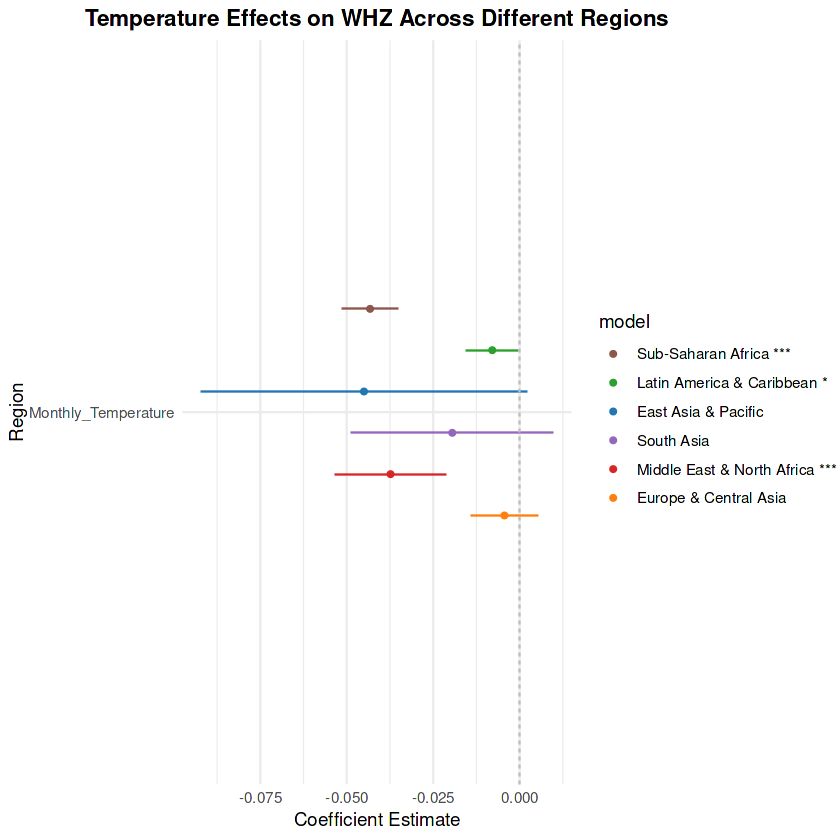

In [37]:
#Models 
model25 <- feols(WHZ ~ Monthly_Temperature | Year + Month + Country, data = Sub_Saharan_Africa_WHZ, cluster = ~Region_id)
model26 <- feols(WHZ ~ Monthly_Temperature | Year + Month + Country, data = Latin_America_Caribbean_WHZ, cluster = ~Region_id)
model27 <- feols(WHZ ~ Monthly_Temperature | Year + Month + Country, data = East_Asia_Pacific_WHZ, cluster = ~Region_id)
model28 <- feols(WHZ ~ Monthly_Temperature | Year + Month + Country, data = South_Asia_WHZ, cluster = ~Region_id)
model29 <- feols(WHZ ~ Monthly_Temperature | Year + Month + Country, data = Middle_East_North_Africa_WHZ, cluster = ~Region_id)
model30 <- feols(WHZ ~ Monthly_Temperature | Year + Month + Country, data = Europe_Central_Asia_WHZ, cluster = ~Region_id)

# Create a named list of models
model_list <- list(
  "Sub-Saharan Africa ***" = model25,
  "Latin America & Caribbean *" = model26,
  "East Asia & Pacific" = model27,
  "South Asia" = model28,
  "Middle East & North Africa ***" = model29,
  "Europe & Central Asia" = model30)

# Create the dot-whisker plot with model labels and color-coded significance stars
dwplot(model_list) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  labs(title = "Temperature Effects on WHZ Across Different Regions",
       x = "Coefficient Estimate",
       y = "Region") +
  # Apply custom colors for each region using scale_color_manual
  scale_color_manual(values = c("East Asia & Pacific" = "#1F77B4", 
                                "Europe & Central Asia" = "#FF7F0E",
                                "Latin America & Caribbean *" = "#2CA02C", 
                                "Middle East & North Africa ***" = "#D62728",
                                "South Asia" = "#9467BD",
                                "Sub-Saharan Africa ***" = "#8C564B" )) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))


# 7. Insights and Discussion

An analysis of children’s nutrition Z-scores from the DHS dataset reveals that 21% of children are underweight, 38% experience stunting, 8% suffer from wasting, and over 45% are at risk of all three conditions. The data, categorized by World Bank regions—Sub-Saharan Africa, South Asia, Middle East & North Africa, Latin America & Caribbean, and East Asia & Pacific—shows that temperatures in these regions generally fluctuate above 20°C. Additionally, 67% of children live in rural areas, with nearly equal representation of boys and girls. Moreover, 65% of households have access to improved water sources, while 27% rely on unimproved sources.

The relationship between WAZ (Weight-for-Age Z-score) and monthly temperature in the East Asia & Pacific and Latin America & Caribbean regions shows a clear positive correlation, unlike other regions where correlations tend to be negative or neutral. Similarly, HAZ (Height-for-Age Z-score) demonstrates a significant positive correlation with temperature in Latin America & Caribbean, as well as in the Middle East & North Africa and South Asia regions. For WHZ (Weight-for-Height Z-score), the East Asia & Pacific region shows a positive relationship with temperature, standing out from the negative correlations observed in other regions.

Overall, the impact of temperature on children’s anthropometric outcomes is relatively small in our models, but WAZ and WHZ still exhibit negative relationships with rising temperatures, suggesting that warmer conditions may adversely affect these indicators. Notably, these temperature effects are not uniform across regions, with some areas experiencing stronger negative impacts than others.

When child-specific control variables such as rural residency and birth order are considered, the analysis indicates that children in urban areas face stepper negative impacts on WAZ, WHZ, and HAZ. Birth order also plays a role, with younger children more likely to experience adverse nutritional outcomes. Gender differences appear minimal, as both boys and girls are similarly affected by these negative impacts.

Maternal control variables offer additional insights. While a mother’s marital status does not show a strong influence, maternal age is positively correlated with better child nutrition outcomes—older mothers tend to have healthier children. Conversely, the number of children in a household is negatively correlated with nutritional outcomes, as larger families are more prone to nutritional challenges.

Regarding water sources, the analysis shows that children from households with both improved and unimproved water sources face similar negative impacts on nutrition, suggesting that other factors beyond water quality may play a role in determining these outcomes.

# 8. Visualizations

To offer an interactive experience, we have created a Child Nutrition and Environmental Factors Dashboard in Tableau. This dashboard allows for an in-depth exploration of the data, where users can filter by regions, nutrition categories, and other important variables to see how these factors influence nutrition outcomes.[Access the Dashboard here.](http://public.tableau.com/views/ChildNutritionandEnvironmentalFactorsDashboard/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link)

# 9. Conclusion

1.**Regional Differences:** In East Asia & Pacific and Latin America & Caribbean, a positive relationship exists between temperature and WAZ/WHZ, while Sub-Saharan Africa and South Asia show negative or neutral effects.

2.**Rural vs. Urban:** Children in urban areas are more negatively affected by temperature, showing lower WAZ, WHZ, and HAZ scores than urban children.

3.**Maternal Factors:** Older mothers have healthier children, while larger families face more nutritional challenges. Marital status has little effect.

4.**Water Source:** There is minimal difference in nutrition outcomes between children with access to improved or unimproved water sources.

5.**Birth Order:** Younger children in families face greater risks of poor nutrition.

**Recommendations:** Target interventions in rural areas, large families, and regions with negative temperature effects, focusing on maternal health, resource access, and climate resilience.